In [1073]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats


In [1149]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [1150]:
path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants with 10% or more missed trials:  20


In [1151]:
missed_trial_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/000691_2014-06-08_13-08...,1000,4.1530,3.0480,4039,1001,meters,807717,956597,32.0
1,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003129_2014-05-12_10-48...,500,4.9305,4.5720,3383,498,meters,807717,956597,32.0
2,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001289_2014-06-16_16-25...,250,1.8835,1.5240,2963,249,meters,807717,956597,32.0
3,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001132_2014-06-17_14-48...,1000,3.7530,3.6576,3766,999,meters,807717,956597,32.0
4,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003495_2014-05-21_16-01...,1000,1.6255,0.9144,3974,1000,meters,807717,956597,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/001808_2014-06-26_20-50...,250,4.2490,7.6200,2884,237,meters,697690,1152795,29.0
44732,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/002199_2014-06-28_18-33...,500,1.9960,2.4384,2304,505,meters,697690,1152795,29.0
44733,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000788_2014-06-08_22-34...,500,3.3590,4.8768,2434,500,meters,697690,1152795,29.0
44734,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000665_2014-06-09_20-42...,750,3.0570,2.4384,3765,759,meters,697690,1152795,29.0


In [1094]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [1152]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


In [1154]:
RT_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/000691_2014-06-08_13-08...,1000,4.1530,3.0480,4039,1001,meters,807717,956597,32.0
1,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003129_2014-05-12_10-48...,500,4.9305,4.5720,3383,498,meters,807717,956597,32.0
2,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001289_2014-06-16_16-25...,250,1.8835,1.5240,2963,249,meters,807717,956597,32.0
3,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001132_2014-06-17_14-48...,1000,3.7530,3.6576,3766,999,meters,807717,956597,32.0
4,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003495_2014-05-21_16-01...,1000,1.6255,0.9144,3974,1000,meters,807717,956597,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/001808_2014-06-26_20-50...,250,4.2490,7.6200,2884,237,meters,697690,1152795,29.0
44732,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/002199_2014-06-28_18-33...,500,1.9960,2.4384,2304,505,meters,697690,1152795,29.0
44733,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000788_2014-06-08_22-34...,500,3.3590,4.8768,2434,500,meters,697690,1152795,29.0
44734,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000665_2014-06-09_20-42...,750,3.0570,2.4384,3765,759,meters,697690,1152795,29.0


In [1155]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [1156]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [1157]:
outlier_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/000691_2014-06-08_13-08...,1000,4.1530,3.0480,4039,1001,meters,807717,956597,32.0
1,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003129_2014-05-12_10-48...,500,4.9305,4.5720,3383,498,meters,807717,956597,32.0
2,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001289_2014-06-16_16-25...,250,1.8835,1.5240,2963,249,meters,807717,956597,32.0
3,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001132_2014-06-17_14-48...,1000,3.7530,3.6576,3766,999,meters,807717,956597,32.0
4,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003495_2014-05-21_16-01...,1000,1.6255,0.9144,3974,1000,meters,807717,956597,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/001808_2014-06-26_20-50...,250,4.2490,7.6200,2884,237,meters,697690,1152795,29.0
44732,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/002199_2014-06-28_18-33...,500,1.9960,2.4384,2304,505,meters,697690,1152795,29.0
44733,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000788_2014-06-08_22-34...,500,3.3590,4.8768,2434,500,meters,697690,1152795,29.0
44734,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000665_2014-06-09_20-42...,750,3.0570,2.4384,3765,759,meters,697690,1152795,29.0


In [1158]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [1159]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.019283990053708 [0.754820997513427, 12.077135960214832]
Avg Estim Cleaning: Number of Participants Removed 12


In [1160]:
avg_estim_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/000691_2014-06-08_13-08...,1000,4.1530,3.0480,4039,1001,meters,807717,956597,32.0
1,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003129_2014-05-12_10-48...,500,4.9305,4.5720,3383,498,meters,807717,956597,32.0
2,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001289_2014-06-16_16-25...,250,1.8835,1.5240,2963,249,meters,807717,956597,32.0
3,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001132_2014-06-17_14-48...,1000,3.7530,3.6576,3766,999,meters,807717,956597,32.0
4,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003495_2014-05-21_16-01...,1000,1.6255,0.9144,3974,1000,meters,807717,956597,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/001808_2014-06-26_20-50...,250,4.2490,7.6200,2884,237,meters,697690,1152795,29.0
44732,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/002199_2014-06-28_18-33...,500,1.9960,2.4384,2304,505,meters,697690,1152795,29.0
44733,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000788_2014-06-08_22-34...,500,3.3590,4.8768,2434,500,meters,697690,1152795,29.0
44734,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000665_2014-06-09_20-42...,750,3.0570,2.4384,3765,759,meters,697690,1152795,29.0


In [1161]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [1162]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(avg_estim_cleaned_data)

Number of participants removed: repeat responses:  10


In [1163]:
repeat_resp_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/000691_2014-06-08_13-08...,1000,4.1530,3.0480,4039,1001,meters,807717,956597,32.0
1,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003129_2014-05-12_10-48...,500,4.9305,4.5720,3383,498,meters,807717,956597,32.0
2,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001289_2014-06-16_16-25...,250,1.8835,1.5240,2963,249,meters,807717,956597,32.0
3,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/001132_2014-06-17_14-48...,1000,3.7530,3.6576,3766,999,meters,807717,956597,32.0
4,657283,DepthScenes,duration_manipulation,ae,http://54.144.246.16/DepthDuration/depth_durat...,18,1920,976,1920,1080,...,depth_duration_stimuli/003495_2014-05-21_16-01...,1000,1.6255,0.9144,3974,1000,meters,807717,956597,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/001808_2014-06-26_20-50...,250,4.2490,7.6200,2884,237,meters,697690,1152795,29.0
44732,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/002199_2014-06-28_18-33...,500,1.9960,2.4384,2304,505,meters,697690,1152795,29.0
44733,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000788_2014-06-08_22-34...,500,3.3590,4.8768,2434,500,meters,697690,1152795,29.0
44734,615398,DepthScenes,duration_manipulation,af,http://54.165.233.113/DepthDuration/depth_dura...,24,1920,1023,1920,1080,...,depth_duration_stimuli/000665_2014-06-09_20-42...,750,3.0570,2.4384,3765,759,meters,697690,1152795,29.0


In [14]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [1164]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  0
Number of participants left:  191


In [1165]:
final_data = cleaned_data.copy(deep=True)

In [1166]:
len(final_data.subjID.unique())

191

### Found a participant with 2 massive obvious typos. Dropped those rows from the final data df

In [1091]:
s = final_data.loc[final_data['subjID'] == 563212]

subjID                                                          563212
experimentName                                             DepthScenes
versionName                                      duration_manipulation
sequenceName                                                         l
url                  http://54.210.105.160/DepthDuration/depth_dura...
selected_row                                                       134
windowWidth                                                       1366
windowHeight                                                       667
screenWidth                                                       1366
screenHeight                                                       768
startDate                                                    2-20-2021
startTime                                                     12-21-31
trial                                                                3
stimulus             depth_duration_stimuli/002414_2014-06-28_20-24...
durati

In [1120]:
final_data.loc[final_data['depth_estimate'] == 138.9888]

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
22358,563212,DepthScenes,duration_manipulation,l,http://54.210.105.160/DepthDuration/depth_dura...,134,1366,667,1366,768,...,depth_duration_stimuli/001136_2014-06-17_15-19...,750,1.8655,138.9888,5273,749,meters,1868327,1908416,45.0


In [1024]:
dp1_remove = final_data[ final_data['depth_estimate']  == 138.9888]
dp2_remove = final_data[ final_data['depth_estimate']  == 172.82160000000002]

final_data = final_data.drop(dp1_remove.index)

final_data = final_data.drop(dp2_remove.index)


In [1026]:
x = 'depth_duration_stimuli/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4-target.png'

stimx = final_data.loc[final_data['stimulus'] == x]

# stimx.loc[stimx['duration'] == 750]

In [1109]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

2.5126223640558063

### Normalize Data by Participant's Avg 

In [746]:
def normalize_dfs(df):
    """
    Args:
        final data 
    Return:
        data normalized by participants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'

    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    norm_subjects = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    return normalized_df

In [1167]:
normalized_data = normalize_dfs(final_data)

#### Age

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


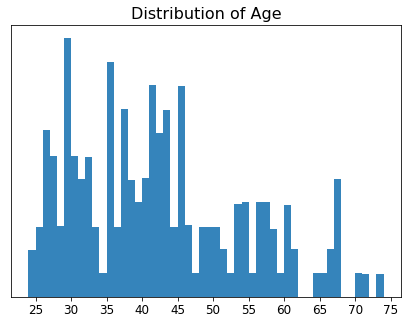

In [1405]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 5) ,fontsize=12)
plt.yticks([])
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.9)
plt.show()


#### Distribution of Participant Average Estimates

In [1406]:
all_subjIDs = final_data.subjID.unique()
avgs = []
for subj in all_subjIDs:
    subj_df = final_data.loc[final_data['subjID'] == subj]
    subj_avg = np.array(subj_df['depth_estimate']).mean()
    avgs.append(subj_avg)
    


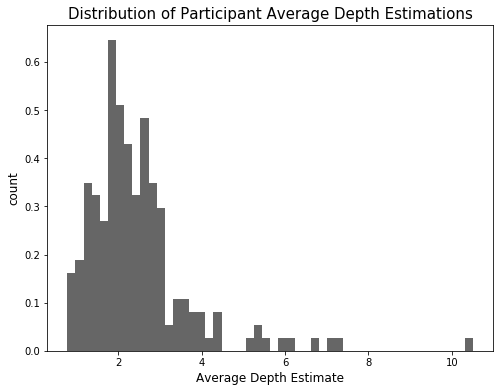

In [1420]:
plt.figure(figsize = [8,6])
plt.title("Distribution of Participant Average Depth Estimations", fontsize = 15)
plt.ylabel("count", fontsize = 12)
plt.xlabel("Average Depth Estimate", fontsize = 12)
_, bins, _ = plt.hist(avgs, 50, density=1, alpha=0.6, color = 'black')
mu, sigma = scipy.stats.norm.fit(avgs)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line, color = 'orange')

plt.show()

### Data split by duration

In [1169]:
data_250ms = final_data[final_data['duration'] == 250.0]
data_500ms = final_data[final_data['duration'] == 500.0]
data_750ms = final_data[final_data['duration'] == 750.0]
data_1000ms = final_data[final_data['duration'] == 1000.0]

duration_data = [data_250ms, data_500ms, data_750ms, data_1000ms]

n_data_250ms = normalized_data[normalized_data['duration'] == 250.0]
n_data_500ms = normalized_data[normalized_data['duration'] == 500.0]
n_data_750ms = normalized_data[normalized_data['duration'] == 750.0]
n_data_1000ms = normalized_data[normalized_data['duration'] == 1000.0]

normalized_duration_data = [n_data_250ms, n_data_500ms, n_data_750ms, n_data_1000ms]


## Results: Averaged across Targets

In [1170]:
def pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
        
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables

In [1171]:
raw_pivot = pivotTable(duration_data)
normalized_pivot = pivotTable(normalized_duration_data)

In [1172]:
def _getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 



In [1173]:
raw_final = _getxy(raw_pivot)
normalized_final = _getxy(normalized_pivot) 


In [1174]:
def _createVars(final_data):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]

In [1175]:
raw_final_vars = _createVars(raw_final)
normalized_final_vars = _createVars(normalized_final)

In [1177]:
#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.
def _durationStatsTests(finaldata):
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 

print("Results")
raw_ttests = _durationStatsTests(raw_final_vars)

print('\n')
print("Normalized Results")
normalized_ttests = _durationStatsTests(normalized_final_vars)

Results
250ms vs. 500ms
Ttest_indResult(statistic=-1.1274770420206988, pvalue=0.2602541235990282)
250ms vs. 750ms
Ttest_indResult(statistic=-1.3559558038818655, pvalue=0.17591844065050163)
250ms vs. 1000ms
Ttest_indResult(statistic=-1.1394266129304462, pvalue=0.2552429929978185)
500ms vs. 750ms
Ttest_indResult(statistic=-0.23489084924563491, pvalue=0.8144196393914622)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.03285585681953288, pvalue=0.973806740098264)
750ms vs. 1000ms
Ttest_indResult(statistic=0.19855962098590957, pvalue=0.8427128738476551)
All durations: fvalue= 0.6980957709912731 pvalue= 0.5533740120610999


Normalized Results
250ms vs. 500ms
Ttest_indResult(statistic=-1.3289670381929328, pvalue=0.18465834745574364)
250ms vs. 750ms
Ttest_indResult(statistic=-1.6657880804887528, pvalue=0.09657972991514574)
250ms vs. 1000ms
Ttest_indResult(statistic=-1.5814951564482127, pvalue=0.11459680247851146)
500ms vs. 750ms
Ttest_indResult(statistic=-0.34499611711143113, pvalue=0.7302876629

## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different

In [1178]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 

def subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes_intercepts = {'subjID': [], 'duration': [], 'block': [], 'slope': [], 'intercept' : []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        block1 = subj_df.loc[subj_df['trial'] < 49]
        temp_block2 = subj_df.loc[subj_df['trial'] <= 96]
        block2 = temp_block2.loc[temp_block2['trial'] >= 49]
        temp_block3 = subj_df.loc[subj_df['trial'] <= 144]
        block3 = temp_block3.loc[temp_block3['trial'] > 96]
        block4 = subj_df.loc[subj_df['trial'] >= 145]
        blocks = [block1, block2, block3, block4]
        
        num_block = 1
        for block in blocks:
            for duration in durations:
                block_duration_subj_df = block.loc[block["duration"]  == duration]
                block_duration_subj_pivot = subject_pivotTable(block_duration_subj_df, duration)
                block_duration_subj_data = subject_getxy(block_duration_subj_pivot)

                x = np.array(block_duration_subj_data[0])
                y = np.array(block_duration_subj_data[1])
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                subj_slopes_intercepts['subjID'].append(subj)
                subj_slopes_intercepts['duration'].append(duration)
                subj_slopes_intercepts['block'].append(num_block)
                subj_slopes_intercepts['slope'].append(slope)
                subj_slopes_intercepts['intercept'].append(intercept)
                
            num_block += 1

    block_duration_df = pd.DataFrame(data=subj_slopes_intercepts)
        
    return block_duration_df  


In [1179]:
subject_duration_block_slopes_intercepts = subjectData(final_data)

normalized_subject_duration_block_slopes_intercepts = subjectData(normalized_data)

In [1535]:
subject_duration_block_slopes_intercepts

,subjID,duration,block,slope,intercept
0,657283,250,1,0.766500,-0.453708
1,657283,500,1,0.765984,-0.497720
2,657283,750,1,1.119920,-1.030364
3,657283,1000,1,0.662286,-0.187650
4,657283,250,2,0.486112,0.148970
...,...,...,...,...,...
3051,615398,1000,3,0.983484,0.119000
3052,615398,250,4,1.410441,-0.776914
3053,615398,500,4,0.899396,0.470716
3054,615398,750,4,1.469389,-1.265160


https://www.pythonfordatascience.org/factorial-anova-python/

In [1181]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols("slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)", data=subject_duration_block_slopes_intercepts).fit()
aov_table = sm.stats.anova_lm(model, typ=2)


In [1183]:
aov_table

,sum_sq,df,F,PR(>F)
"C(duration, Sum)",7.182060,3.0,10.285987,9.795668e-07
"C(block, Sum)",0.226322,3.0,0.324134,8.079287e-01
"C(duration, Sum):C(block, Sum)",0.812760,9.0,0.388006,9.414583e-01
Residual,707.547136,3040.0,NaN,NaN


The interaction between block and duration is statistically non-significant. This indicates that different level combinations of the factors do not produce a significant difference in the participant slopes. 

In [854]:
# plt.rc('figure', figsize=(12, 7))
# #plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
# plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('output.png')

In [1184]:
norm_model = ols("slope ~ C(duration, Sum) + C(block, Sum) + C(duration, Sum)*C(block, Sum)", data=normalized_subject_duration_block_slopes_intercepts).fit()
norm_aov_table = sm.stats.anova_lm(norm_model, typ=2)


In [1185]:
norm_aov_table

,sum_sq,df,F,PR(>F)
"C(duration, Sum)",1.823441,3.0,25.412346,3.110617e-16
"C(block, Sum)",0.030985,3.0,0.431824,7.302237e-01
"C(duration, Sum):C(block, Sum)",0.088413,9.0,0.410720,9.301139e-01
Residual,72.710858,3040.0,NaN,NaN


In [1186]:
def AnovaRM_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)

            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

In [1530]:
df_slope, df_intercept = AnovaRM_subjectData(final_data)
norm_df_slope, norm_df_intercept = AnovaRM_subjectData(normalized_data)

df_slope

,subjID,duration,slope
0,657283,250,0.603500
1,657283,500,0.905249
2,657283,750,1.076644
3,657283,1000,0.791387
4,984878,250,0.190871
...,...,...,...
759,808882,1000,0.710866
760,615398,250,0.972457
761,615398,500,1.079459
762,615398,750,1.177825


In [1531]:
slopes_250 = df_slope.loc[df_slope['duration'] == 250]
slopes_500 = df_slope.loc[df_slope['duration'] == 500]
slopes_750 = df_slope.loc[df_slope['duration'] == 750]
slopes_1000 = df_slope.loc[df_slope['duration'] == 1000]

In [1532]:
print("250ms vs. 500ms")
ttest_250_500 = stats.ttest_ind(slopes_250['slope'],slopes_500['slope'])
print(ttest_250_500)
print("250ms vs. 750ms")
ttest_250_750 = stats.ttest_ind(slopes_250['slope'],slopes_750['slope'])
print(ttest_250_750)
print("250ms vs. 1000ms")
ttest_250_1000 = stats.ttest_ind(slopes_250['slope'],slopes_1000['slope'])
print(ttest_250_1000)
print("500ms vs. 750ms")
ttest_500_750 = stats.ttest_ind(slopes_500['slope'],slopes_750['slope'])
print(ttest_500_750)
print("500ms vs. 1000ms")
ttest_500_1000 = stats.ttest_ind(slopes_500['slope'],slopes_1000['slope'])
print(ttest_500_1000)
print("750ms vs. 1000ms")
ttest_750_1000 = stats.ttest_ind(slopes_750['slope'],slopes_1000['slope'])
print(ttest_750_1000)

250ms vs. 500ms
Ttest_indResult(statistic=-2.330430394337033, pvalue=0.02030615909044676)
250ms vs. 750ms
Ttest_indResult(statistic=-3.1808698276334826, pvalue=0.0015889776056638657)
250ms vs. 1000ms
Ttest_indResult(statistic=-2.820322537011778, pvalue=0.005049065672861294)
500ms vs. 750ms
Ttest_indResult(statistic=-0.8804307774162049, pvalue=0.37918246406974754)
500ms vs. 1000ms
Ttest_indResult(statistic=-0.7453601813319229, pvalue=0.4565147780438923)
750ms vs. 1000ms
Ttest_indResult(statistic=0.05633182339844342, pvalue=0.9551070746096172)


In [1533]:
n_slopes_250 = norm_df_slope.loc[norm_df_slope['duration'] == 250]
n_slopes_500 = norm_df_slope.loc[norm_df_slope['duration'] == 500]
n_slopes_750 = norm_df_slope.loc[norm_df_slope['duration'] == 750]
n_slopes_1000 = norm_df_slope.loc[norm_df_slope['duration'] == 1000]

In [1534]:
print("250ms vs. 500ms")
n_ttest_250_500 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_500['slope'])
print(n_ttest_250_500)
print("250ms vs. 750ms")
n_ttest_250_750 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_750['slope'])
print(n_ttest_250_750)
print("250ms vs. 1000ms")
n_ttest_250_1000 = stats.ttest_ind(n_slopes_250['slope'],n_slopes_1000['slope'])
print(n_ttest_250_1000)
print("500ms vs. 750ms")
n_ttest_500_750 = stats.ttest_ind(n_slopes_500['slope'],n_slopes_750['slope'])
print(n_ttest_500_750)
print("500ms vs. 1000ms")
n_ttest_500_1000 = stats.ttest_ind(n_slopes_500['slope'],n_slopes_1000['slope'])
print(n_ttest_500_1000)
print("750ms vs. 1000ms")
n_ttest_750_1000 = stats.ttest_ind(n_slopes_750['slope'],n_slopes_1000['slope'])
print(n_ttest_750_1000)

250ms vs. 500ms
Ttest_indResult(statistic=-3.6808501168485517, pvalue=0.0002660777946281212)
250ms vs. 750ms
Ttest_indResult(statistic=-4.807157204232441, pvalue=2.209129875540664e-06)
250ms vs. 1000ms
Ttest_indResult(statistic=-4.766017299469468, pvalue=2.6799667111007794e-06)
500ms vs. 750ms
Ttest_indResult(statistic=-1.2349528916744756, pvalue=0.21761107618868017)
500ms vs. 1000ms
Ttest_indResult(statistic=-1.333104327256165, pvalue=0.1832962282836228)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.13536383450710024, pvalue=0.8923958906497385)


In [1188]:
print("DV: Slope")
print(AnovaRM(data=df_slope, depvar='slope', subject='subjID', within=['duration']).fit())
print("DV: Intercept")
print(AnovaRM(data=df_intercept, depvar='intercept', subject='subjID', within=['duration']).fit())


DV: Slope
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 13.5874 3.0000 570.0000 0.0000

DV: Intercept
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration  6.2359 3.0000 570.0000 0.0004



In [1189]:
print("Normalized Data: Repeated Measures ANOVA")
print("DV: Slope")
print(AnovaRM(data=norm_df_slope, depvar='slope', subject='subjID', within=['duration']).fit())
print("DV: Intercept")
print(AnovaRM(data=norm_df_intercept, depvar='intercept', subject='subjID', within=['duration']).fit())



Normalized Data: Repeated Measures ANOVA
DV: Slope
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 50.3252 3.0000 570.0000 0.0000

DV: Intercept
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 25.0101 3.0000 570.0000 0.0000



In [717]:
def ANCOVA_subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    durations = [250, 500, 750, 1000]
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        for duration in durations:
            duration_subj_df = subj_df.loc[subj_df["duration"]  == duration]
            duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
            duration_subj_data = subject_getxy(duration_subj_pivot)
            
            x = np.array(duration_subj_data[0])
            y = np.array(duration_subj_data[1])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            subj_slopes['subjID'].append(subj)
            subj_slopes['duration'].append(duration)
            subj_slopes['slope'].append(slope)
            subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
            subj_intercepts['subjID'].append(subj)
            subj_intercepts['duration'].append(duration)            
            subj_intercepts['intercept'].append(intercept)
            subj_intercepts['age'].append(duration_subj_df.age.unique()[0])


                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

In [1190]:
df_age_slope, df_age_intercept = ANCOVA_subjectData(final_data)

In [1191]:
df_age_slope_250 = df_age_slope.loc[df_age_slope['duration'] == 250] 
df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

df_age_slope_500 = df_age_slope.loc[df_age_slope['duration'] == 500] 
df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

df_age_slope_750 = df_age_slope.loc[df_age_slope['duration'] == 750] 
df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

df_age_slope_1000 = df_age_slope.loc[df_age_slope['duration'] == 1000] 
df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

In [1192]:
df_age_slope

,subjID,duration,slope,age
0,657283,250,0.603500,32.0
1,657283,500,0.905249,32.0
2,657283,750,1.076644,32.0
3,657283,1000,0.791387,32.0
4,984878,250,0.190871,53.0
...,...,...,...,...
759,808882,1000,0.710866,NaN
760,615398,250,0.972457,29.0
761,615398,500,1.079459,29.0
762,615398,750,1.177825,29.0


0.010124819238436248
0.008568823474127183
0.00038999237729950916
0.0010282124618066159


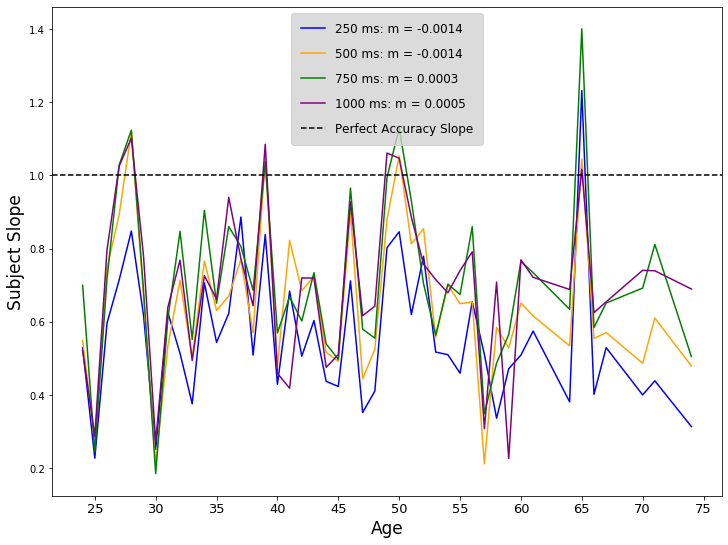

In [1195]:
plt.figure(figsize = [12, 9])
plt.xticks(np.arange(20, 80, 5), fontsize = 13)
plt.yticks(np.arange(0, 1.8, 0.2))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)

ages = df_age_slope_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

In [1194]:
norm_df_age_slope, norm_df_age_intercept = ANCOVA_subjectData(normalized_data)

In [1458]:
df_age_slope_250 = norm_df_age_slope.loc[df_age_slope['duration'] == 250] 
df_age_slope_250_mean = df_age_slope_250.groupby('age').mean()

df_age_slope_500 = norm_df_age_slope.loc[df_age_slope['duration'] == 500] 
df_age_slope_500_mean = df_age_slope_500.groupby('age').mean()

df_age_slope_750 = norm_df_age_slope.loc[df_age_slope['duration'] == 750] 
df_age_slope_750_mean = df_age_slope_750.groupby('age').mean()

df_age_slope_1000 = norm_df_age_slope.loc[df_age_slope['duration'] == 1000] 
df_age_slope_1000_mean = df_age_slope_1000.groupby('age').mean()

https://pingouin-stats.org/generated/pingouin.ancova.html

In [1196]:
from pingouin import ancova, read_dataset

print("DV: Slope")
ancova(data=df_age_slope, dv='slope', covar='age', between='duration')

DV: Slope


,Source,SS,DF,F,p-unc,np2
0,duration,1.749740,3,3.967880,0.008051,0.016466
1,age,0.089504,1,0.608905,0.435460,0.000856
2,Residual,104.511316,711,NaN,NaN,NaN


In [1198]:
print("DV: Intercept")
ancova(data=df_age_intercept, dv='intercept', covar='age', between='duration')

DV: Intercept


,Source,SS,DF,F,p-unc,np2
0,duration,7.261029,3,1.251744,0.289995,0.005254
1,age,0.237569,1,0.122865,0.726052,0.000173
2,Residual,1374.773411,711,NaN,NaN,NaN


In [1055]:
print("DV: Normalized Slope")
ancova(data=norm_df_age_slope, dv='slope', covar='age', between='duration')

DV: Normalized Slope


,Source,SS,DF,F,p-unc,np2
0,duration,0.617932,3,12.187909,8.732078e-08,0.048650
1,age,0.023984,1,1.419159,2.339371e-01,0.001981
2,Residual,12.083607,715,NaN,NaN,NaN


In [1056]:
print("DV: Normalized Intercept")
ancova(data=norm_df_age_intercept, dv='intercept', covar='age', between='duration')

DV: Normalized Intercept


,Source,SS,DF,F,p-unc,np2
0,duration,2.628199,3,5.856403,0.000593,0.023983
1,age,0.214452,1,1.433585,0.231577,0.002001
2,Residual,106.957692,715,NaN,NaN,NaN


0.09094427560464798
0.03822833282153035
0.002528382916441684
0.0002662177342842361


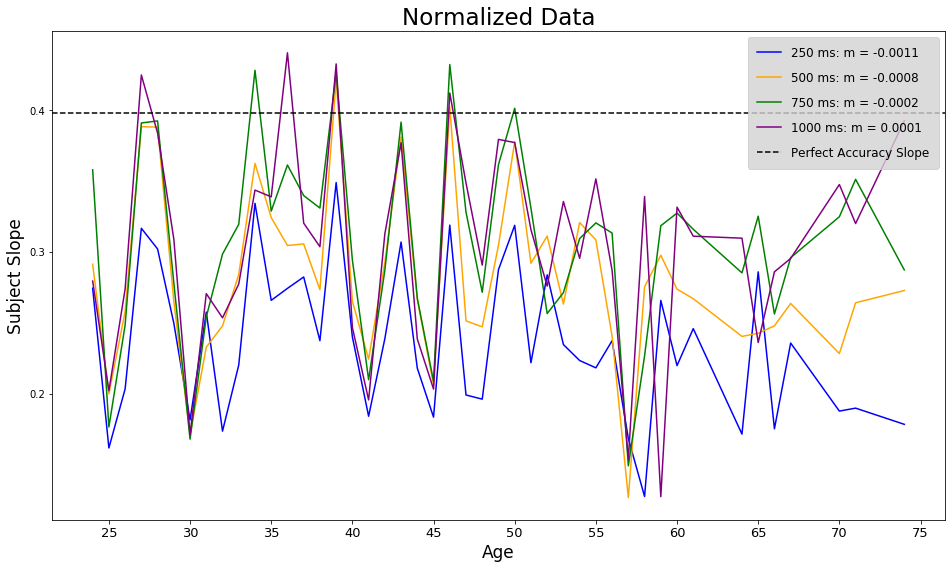

In [1467]:
plt.figure(figsize = [16, 9])
plt.xticks(np.arange(20, 80, 5), fontsize = 13)
plt.yticks(np.arange(0, 1.8, 0.1))
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Subject Slope", fontsize = 17)

ages = df_age_slope_250_mean.index

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(ages, df_age_slope_250_mean['slope'])
plt.plot(ages, df_age_slope_250_mean['slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "blue")
# plt.plot(ages, intercept_250 + slope_250*ages, 'r', color = "blue")
print(r_value_250 **2)

slope_500, intercept_500, r_value_500, p_value_500, std_err_500 = stats.linregress(ages, df_age_slope_500_mean['slope'])
plt.plot(ages, df_age_slope_500_mean['slope'], label = '500 ms: m = ' + str(round(slope_500, 4)), color = "orange")
# plt.plot(ages, intercept_500 + slope_500*ages, 'r',  color = "orange")
print(r_value_500 **2)

slope_750, intercept_750, r_value_750, p_value_750, std_err_750 = stats.linregress(ages, df_age_slope_750_mean['slope'])
plt.plot(ages, df_age_slope_750_mean['slope'], label = '750 ms: m = ' + str(round(slope_750, 4)), color = "green")
# plt.plot(ages, intercept_750 + slope_750*ages, 'r', color = "green")
print(r_value_750 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(ages, df_age_slope_1000_mean['slope'])
plt.plot(ages, df_age_slope_1000_mean['slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "purple")
# plt.plot(ages, intercept_1000 + slope_1000*ages, 'r',  color = "purple")
print(r_value_1000 **2)

plt.axhline(y=1/average_depth_estimate, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")

plt.title("Normalized Data", fontsize = 23)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

## Plot Duration Slopes

### Raw Data

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def linreg_duration(x, y, ste, duration):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value, std_err

In [1399]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = raw_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.55820625]
b: 0.6960724191526557
R-squared:  0.6427063575608344


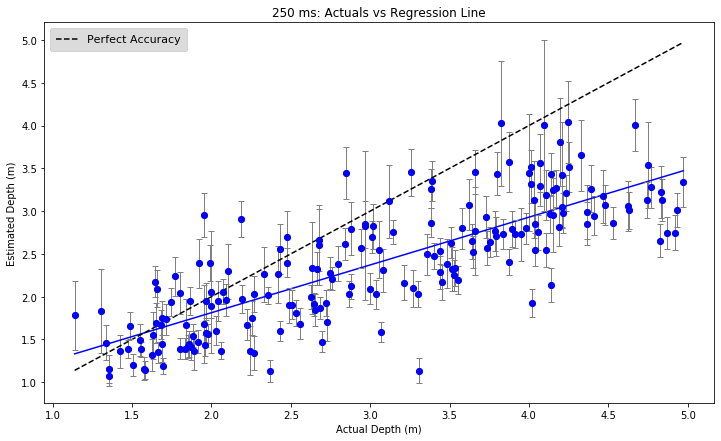

In [1400]:
from sklearn.linear_model import LinearRegression
#run regression
X_250 = np.array(final_x_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='blue')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

Text(0, 0.5, 'Residual')

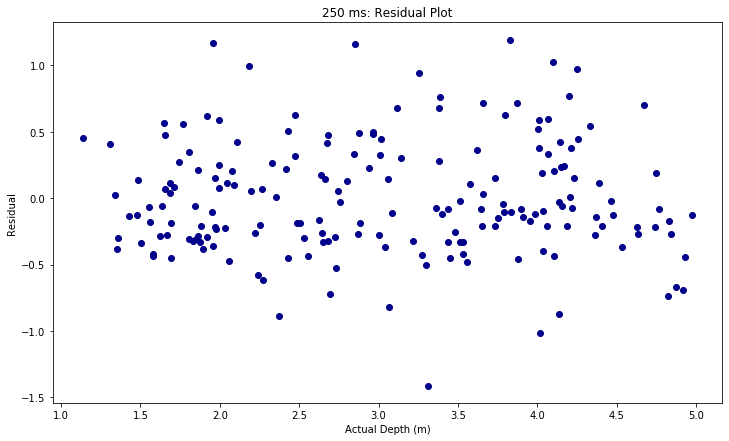

In [1206]:
residuals_250 = y_250-y_predicted_250
plt.plot(X_250,residuals_250, 'o', color='darkblue')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1207]:
# http://www.hackdeploy.com/python-linear-regression-analysis/

In [1208]:
slope_250 = linreg_duration(final_x_250, final_y_250, ste_250, 250)[0]
slope_250

0.5582062474211295

m: [0.64910659]
b: 0.5150054629506355
R-squared:  0.6673477897932695


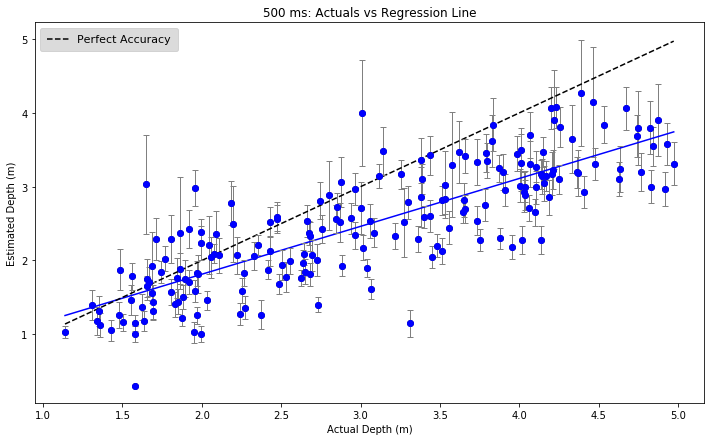

In [1402]:
from sklearn.linear_model import LinearRegression
#run regression
X_500 = np.array(final_x_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black', alpha = 0.7);
plt.plot(X_500,y_predicted_500,color='blue')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_500, y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

Text(0, 0.5, 'Residual')

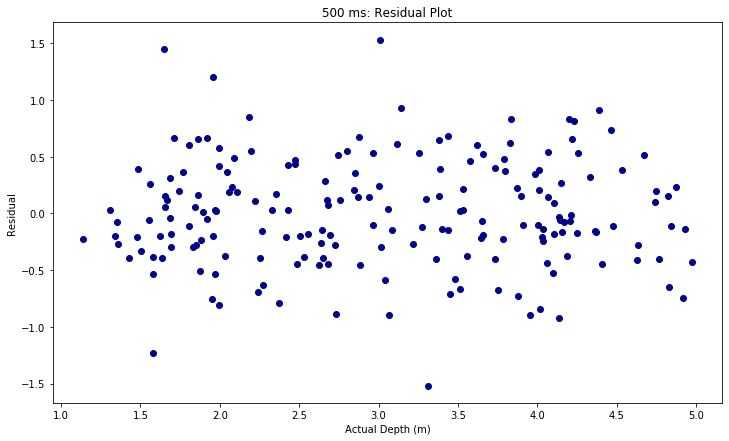

In [1210]:
residuals_500 = y_500-y_predicted_500
plt.plot(X_500,residuals_500, 'o', color='darkblue')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1211]:
slope_500 = linreg_duration(final_x_500, final_y_500, ste_500, 500)[0]
slope_500

0.6491065884027858

m: [0.67890687]
b: 0.43782102844056814
R-squared:  0.6752884915700075


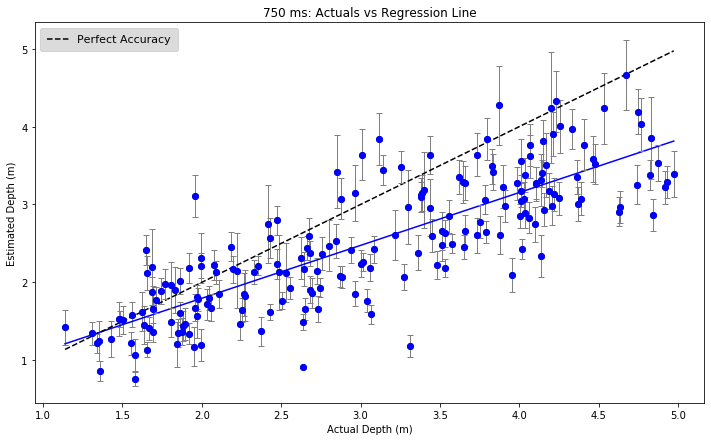

In [1403]:
from sklearn.linear_model import LinearRegression
#run regression
X_750 = np.array(final_x_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black', alpha = 0.7);
plt.plot(X_750,y_predicted_750,color='blue')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_750, y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

Text(0, 0.5, 'Residual')

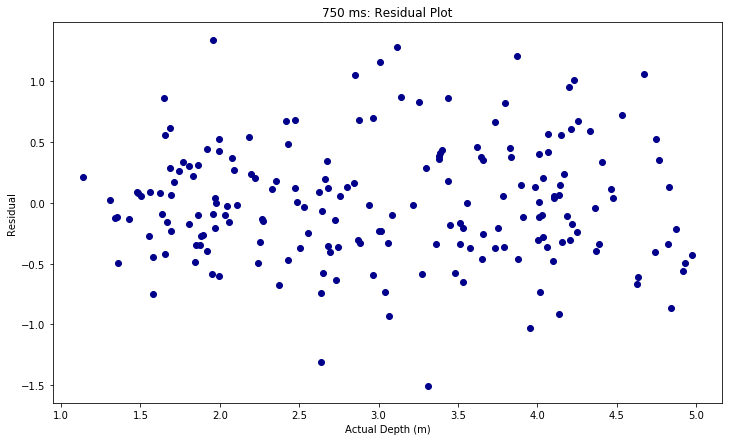

In [1213]:
residuals_750 = y_750-y_predicted_750
plt.plot(X_750,residuals_750, 'o', color='darkblue')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1214]:
slope_750 = linreg_duration(final_x_750, final_y_750, ste_750, 750)[0]
slope_750

0.6789068698583935

m: [0.68251032]
b: 0.42144414247948614
R-squared:  0.6866747103037141


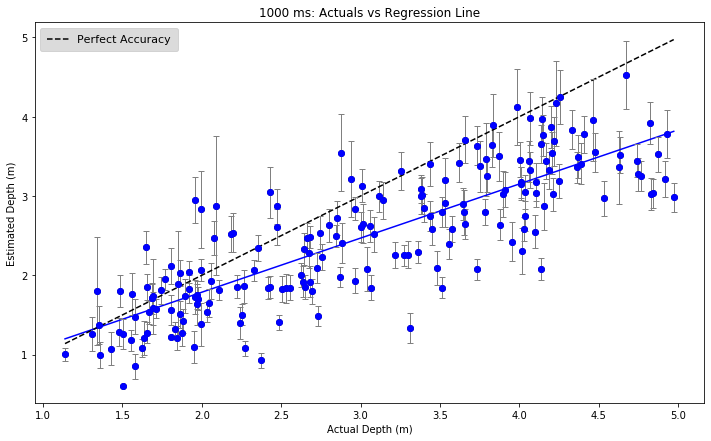

In [1404]:
from sklearn.linear_model import LinearRegression
#run regression
X_1000 = np.array(final_x_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='blue')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

Text(0, 0.5, 'Residual')

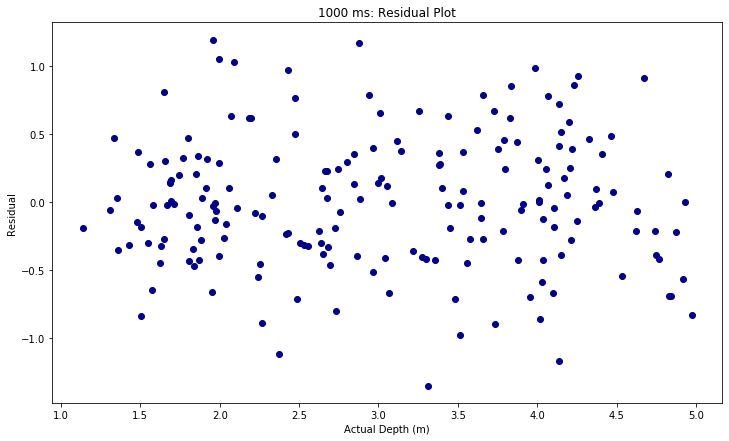

In [1216]:
residuals_1000 = y_1000-y_predicted_1000
plt.plot(X_1000,residuals_1000, 'o', color='darkblue')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1217]:
slope_1000 = linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000)[0]
slope_1000

0.6825103168476324

#### Summary Plots for Non-Normalized Data

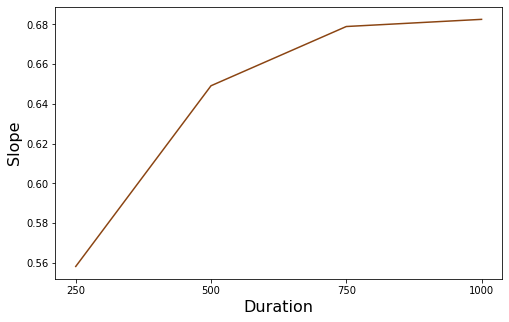

In [1218]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 5])
plt.plot(xAxis,slopes, color="saddlebrown")
plt.xlabel('Duration', fontsize=16)
plt.ylabel('Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

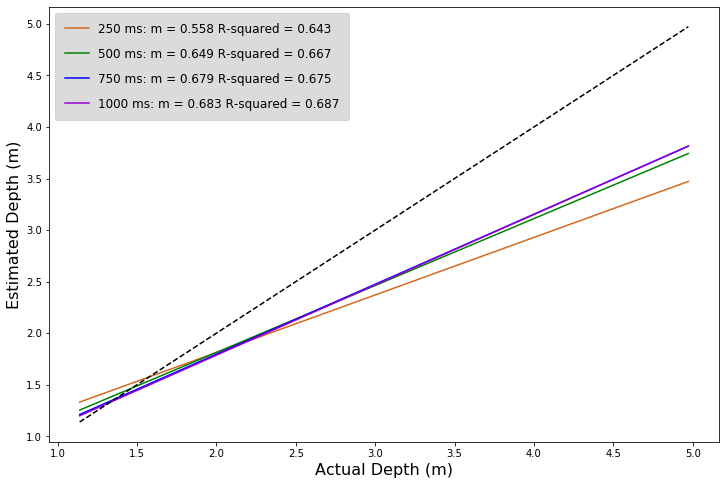

In [1219]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

### Normalized Data

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_linreg_duration(x, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    
    return slope, intercept, r_value, p_value, std_err

In [1450]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = normalized_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.23157789]
b: 0.26076704598547196
R-squared:  0.6821174819573708


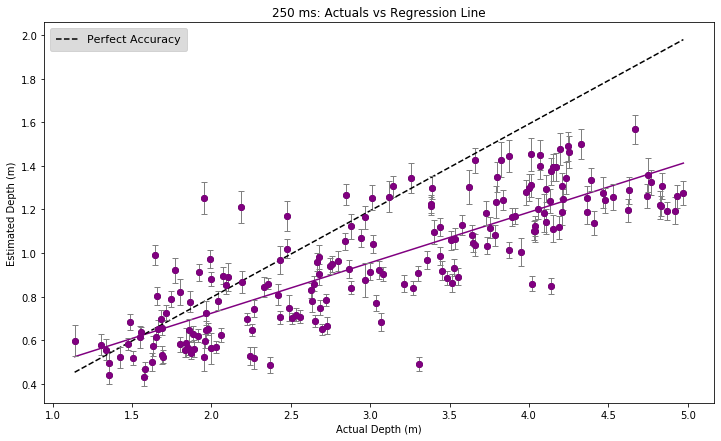

In [1454]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_250 = np.array(final_x_250).reshape(-1,1)
n_y_250 = final_y_250
n_reg_250 = LinearRegression().fit(n_X_250, n_y_250)

#Generated Predictions
n_y_predicted_250 = n_reg_250.predict(n_X_250)
#Plot Our Actual and Predicted Values
plt.plot(n_X_250, n_y_250, 'o', color='black', alpha = 0.7);
plt.plot(n_X_250,n_y_predicted_250,color='purple')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_250, n_X_250/average_depth_estimate, 
         label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_250, final_y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(n_reg_250.coef_))
print("b: {0}".format(n_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_250.score(n_X_250, n_y_250))

Text(0, 0.5, 'Residual')

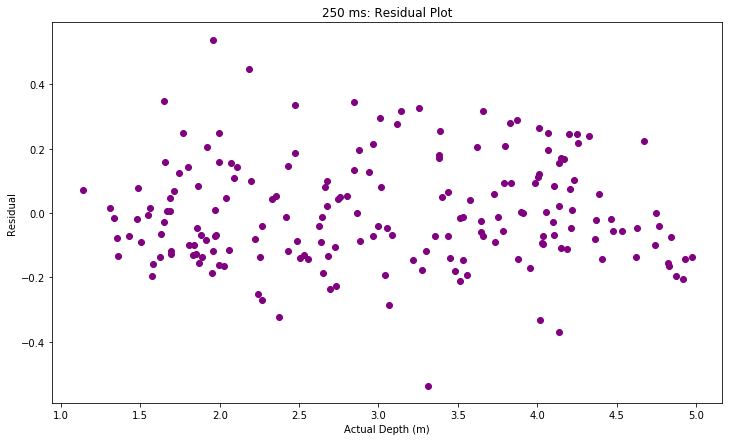

In [1222]:
n_residuals_250 = n_y_250-n_y_predicted_250
plt.plot(n_X_250,n_residuals_250, 'o', color='purple')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1223]:
slope_250 = normalized_linreg_duration(final_x_250, final_y_250, ste_250, 250,
                                       average_depth_estimate)[0]

m: [0.2772328]
b: 0.16744408367254593
R-squared:  0.7231098458605416


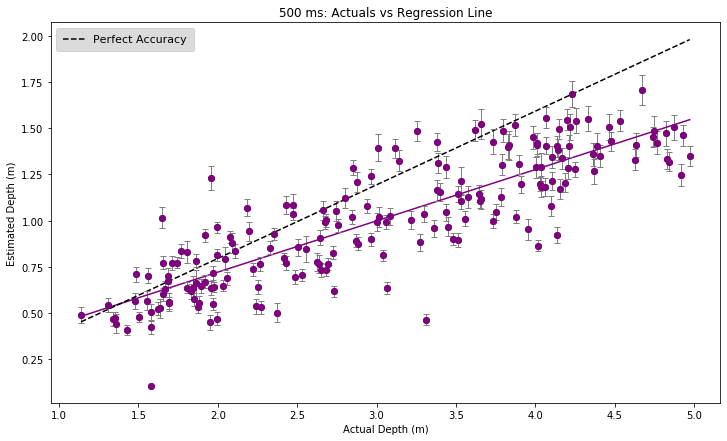

In [1455]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_500 = np.array(final_x_500).reshape(-1,1)
n_y_500 = final_y_500
n_reg_500 = LinearRegression().fit(n_X_500, n_y_500)

#Generated Predictions
n_y_predicted_500 = n_reg_500.predict(n_X_500)
#Plot Our Actual and Predicted Values
plt.plot(n_X_500, n_y_500, 'o', color='black', alpha = 0.7);
plt.plot(n_X_500,n_y_predicted_500,color='purple')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_500, n_X_500/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_500, final_y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_500.coef_))
print("b: {0}".format(n_reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_500.score(n_X_500, n_y_500))

Text(0, 0.5, 'Residual')

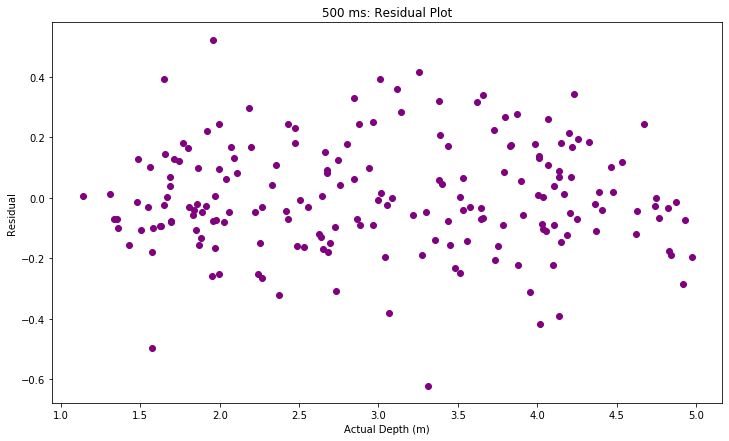

In [1225]:
n_residuals_500 = n_y_500-n_y_predicted_500
plt.plot(n_X_500,n_residuals_500, 'o', color='purple')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1226]:
slope_500 = normalized_linreg_duration(final_x_500, final_y_500, ste_500, 500,
                                       average_depth_estimate)[0]

m: [0.29101679]
b: 0.1348639443270765
R-squared:  0.724128423835656


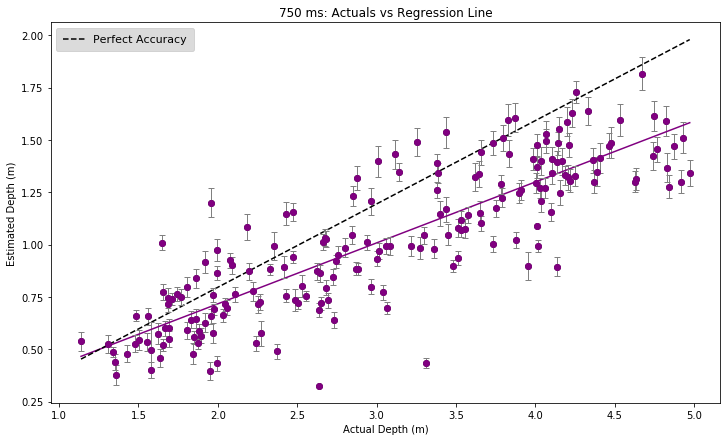

In [1456]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_750 = np.array(final_x_750).reshape(-1,1)
n_y_750 = final_y_750
n_reg_750 = LinearRegression().fit(n_X_750, n_y_750)

#Generated Predictions
n_y_predicted_750 = n_reg_750.predict(n_X_750)
#Plot Our Actual and Predicted Values
plt.plot(n_X_750, n_y_750, 'o', color='black', alpha = 0.7);
plt.plot(n_X_750,n_y_predicted_750,color='purple')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_750, n_X_750/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_750, final_y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(n_reg_750.coef_))
print("b: {0}".format(n_reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_750.score(n_X_750, n_y_750))

Text(0, 0.5, 'Residual')

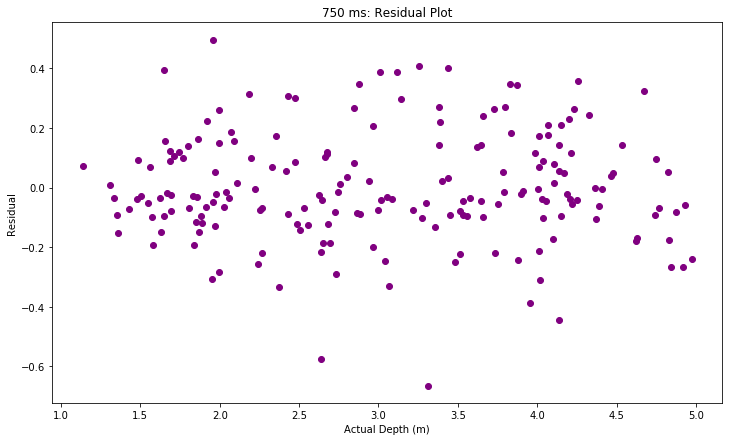

In [1228]:
n_residuals_750 = n_y_750-n_y_predicted_750
plt.plot(n_X_750,n_residuals_750, 'o', color='purple')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1229]:
slope_750 = normalized_linreg_duration(final_x_750, final_y_750, ste_750, 750,
                                       average_depth_estimate)[0]

m: [0.29598105]
b: 0.12252877376943816
R-squared:  0.7414985156164179


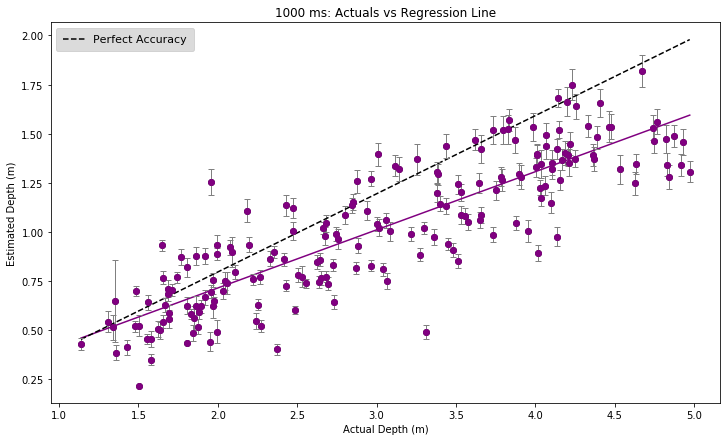

In [1457]:
from sklearn.linear_model import LinearRegression
#run regression
n_X_1000 = np.array(final_x_1000).reshape(-1,1)
n_y_1000 = final_y_1000
n_reg_1000 = LinearRegression().fit(n_X_1000, n_y_1000)

#Generated Predictions
n_y_predicted_1000 = n_reg_1000.predict(n_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(n_X_1000, n_y_1000, 'o', color='black', alpha = 0.7);
plt.plot(n_X_1000,n_y_predicted_1000,color='purple')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(n_X_1000, final_y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "purple", mec = "purple", capsize = 3)
legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(n_reg_1000.coef_))
print("b: {0}".format(n_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", n_reg_1000.score(n_X_1000, n_y_1000))

Text(0, 0.5, 'Residual')

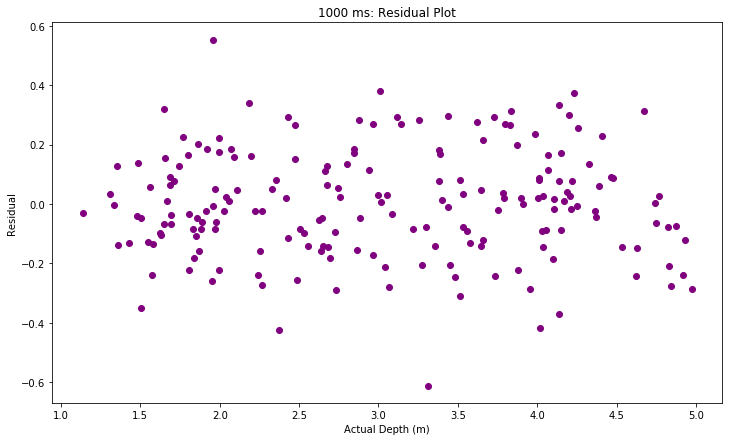

In [1231]:
n_residuals_1000 = n_y_1000-n_y_predicted_1000
plt.plot(n_X_1000,n_residuals_1000, 'o', color='purple')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [1232]:
slope_1000 = normalized_linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000,
                                       average_depth_estimate)[0]

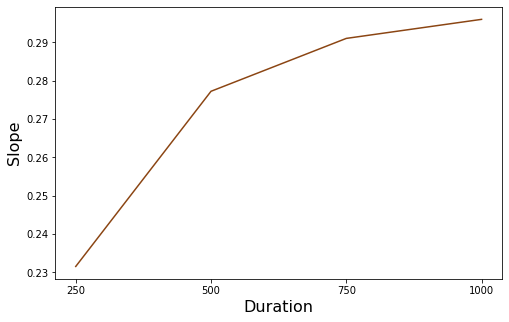

In [1447]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.figure(figsize = [8, 5])
plt.plot(xAxis,slopes, color="saddlebrown")
plt.xlabel('Duration', fontsize=16)
plt.ylabel('Slope', fontsize=16)
# plt.title("Linear Model Slopes by Duration", fontsize = 20)

plt.show()

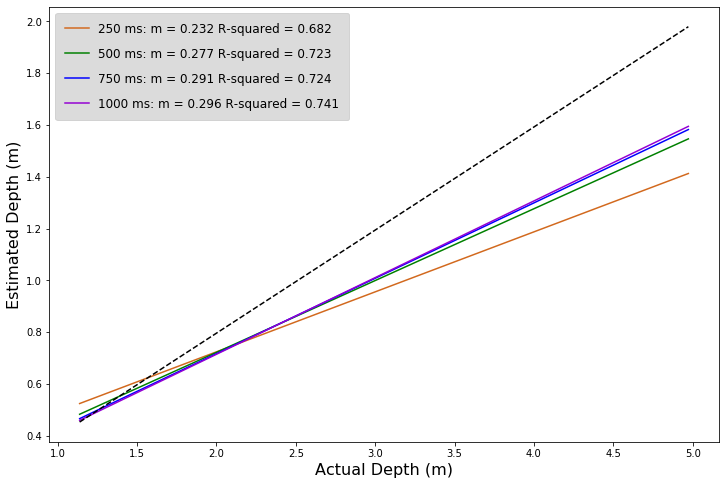

In [1234]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(n_X_250,n_y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(n_reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_250.score(n_X_250, n_y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(n_X_500,n_y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(n_reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_500.score(n_X_500, n_y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(n_X_750,n_y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(n_reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(n_reg_750.score(n_X_750, n_y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(n_X_1000,n_y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(n_reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(n_reg_1000.score(n_X_1000, n_y_1000), 3)))

# plt.title("Normalized Data", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(n_X_1000, n_X_1000/average_depth_estimate, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

## Individual Target Results

In [98]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables



In [1235]:
raw_trial_pivot = trial_pivotTable(duration_data)
normalized_trial_pivot = trial_pivotTable(normalized_duration_data)


In [101]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)

    return xs, ys, stes, actualdepths, stds



In [1485]:
trial_raw_final = trial_getxy(raw_trial_pivot)
trial_normalized_final = trial_getxy(normalized_trial_pivot)

#### Raw Data

In [1486]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]
std_250 = trial_plot_data[4][0]

final_x_500 = trial_plot_data[0][1]
final_y_500 = trial_plot_data[1][1]
ste_500 = trial_plot_data[2][1]
stim_500 = trial_plot_data[3][1]
std_500 = trial_plot_data[4][1]


final_x_750 = trial_plot_data[0][2]
final_y_750 = trial_plot_data[1][2]
ste_750 = trial_plot_data[2][2]
stim_750 = trial_plot_data[3][2]
std_750 = trial_plot_data[4][2]


final_x_1000 = trial_plot_data[0][3]
final_y_1000 = trial_plot_data[1][3]
ste_1000 = trial_plot_data[2][3]
stim_1000 = trial_plot_data[3][3]
std_1000 = trial_plot_data[4][3]


In [1487]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value, std_err
    

In [1488]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_ste(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(ste)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.13, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.15, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 5, step = 0.1))
    plt.title(label = "Individual Target Standard Error: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Error")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "chocolate")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "chocolate")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [1489]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_std(actual_depth, y, std, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(std) # STD not Y 
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 2, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 2.5, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 8, step = 1))
    plt.title(label = "Individual Target Standard Deviation: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Deviation")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "olive")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "olive")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.55940644]
b: 0.691235051176452
R-squared:  0.6441297477011338


Text(0, 0.5, 'Residual')

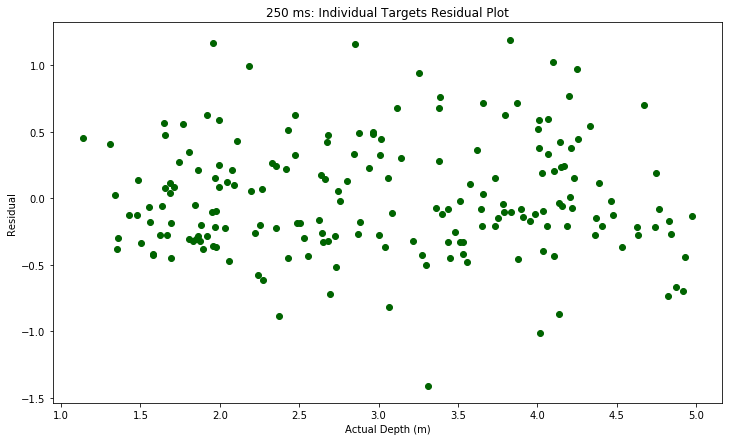

In [1490]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_250 = y-y_predicted
plt.plot(X,residuals_250, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

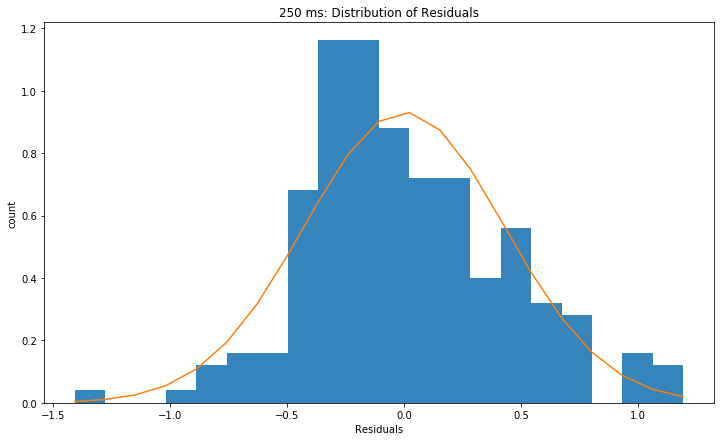

In [1491]:
import scipy 
plt.title('250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals_250, 20, density=1, alpha=0.9)
mu_250, sigma = scipy.stats.norm.fit(residuals_250)
best_fit_line_250 = scipy.stats.norm.pdf(bins, mu_250, sigma)
plt.plot(bins, best_fit_line_250)

plt.show()

m: [0.55940644]
b: 0.691235051176452
R-squared:  0.6441297477011338


0.644

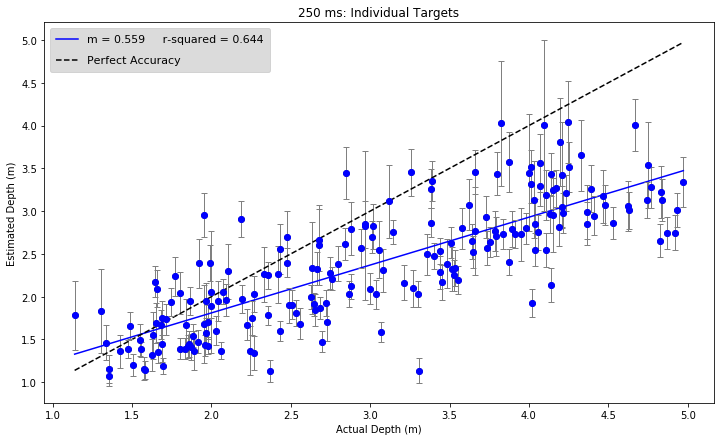

In [1492]:
from sklearn.linear_model import LinearRegression
#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='blue', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.title("250 ms: Individual Targets")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

round(float(reg_250.score(X_250, y_250)), 3)

slope: 0.032953    intercept: 0.141073
R-squared: 0.066832
Standard-error: 0.008933


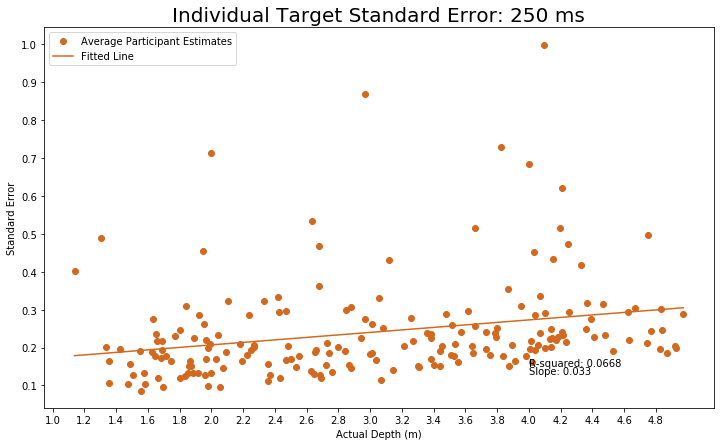

Average Standard Error 250 ms


0.2406295208903312

In [1493]:
plot_img_ste(stim_250, final_y_250, ste_250, 250)

avg_250 =np.mean(ste_250)
print("Average Standard Error 250 ms")
avg_250

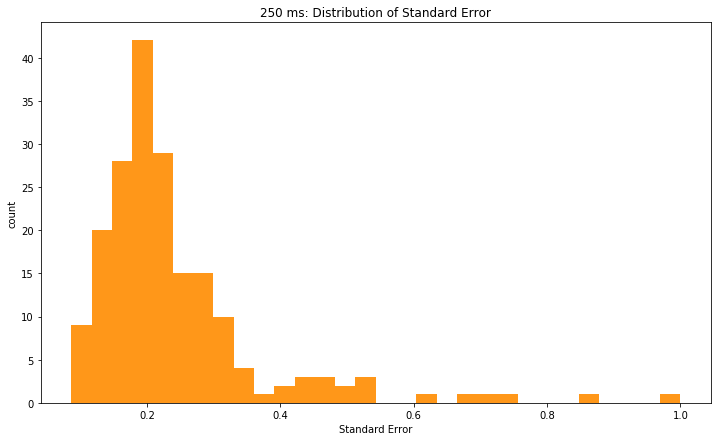

In [1494]:
plt.hist(ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.225110    intercept: 0.950496
R-squared: 0.067522
Standard-error: 0.060690


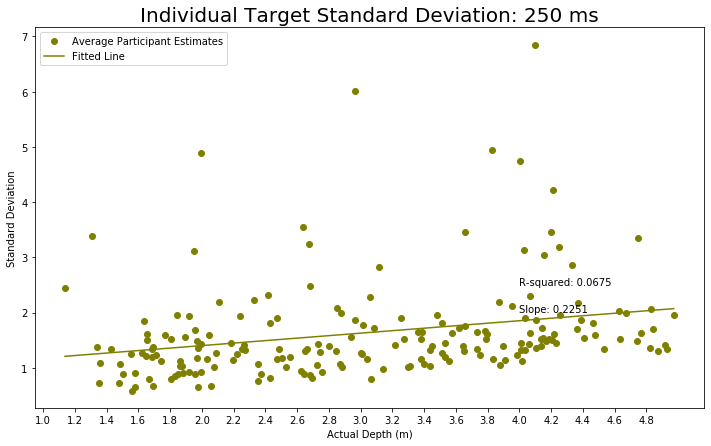

(0.2251100632325052,
 0.9504959840264812,
 0.2598497291457432,
 0.0002728537194297642,
 0.060689724453831424)

In [1495]:
plot_img_std(stim_250, final_y_250, std_250, 250)

Look at images with standard errors on the tail of the distribution

m: [0.63986129]
b: 0.5501860422899998
R-squared:  0.6664129443432678


Text(0, 0.5, 'Residual')

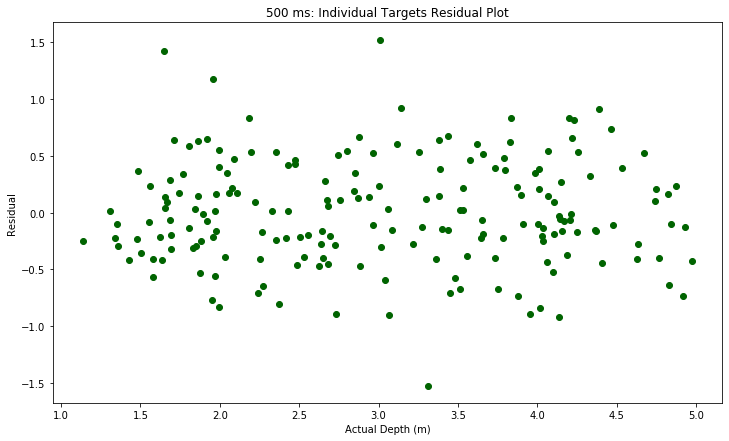

In [1496]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_500).reshape(-1,1)
y = final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_500 = y-y_predicted
plt.plot(X,residuals_500, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

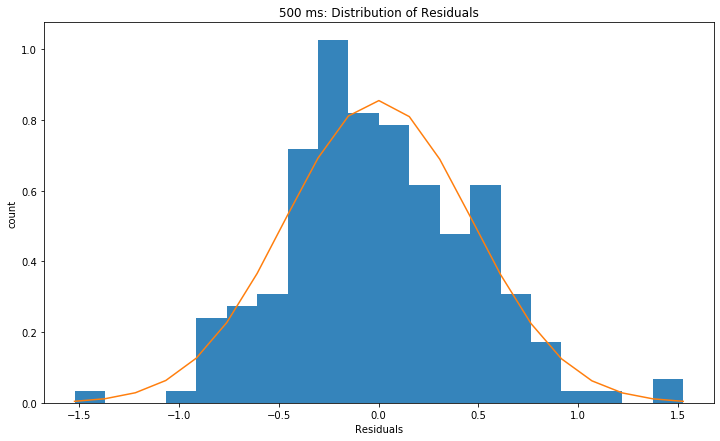

In [1497]:
plt.title('500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals_500, 20, density=1, alpha=0.9)
mu_500, sigma = scipy.stats.norm.fit(residuals_500)
best_fit_line_500 = scipy.stats.norm.pdf(bins, mu_500, sigma)
plt.plot(bins, best_fit_line_500)

plt.show()

m: [0.63986129]
b: 0.5501860422899998
R-squared:  0.6664129443432678


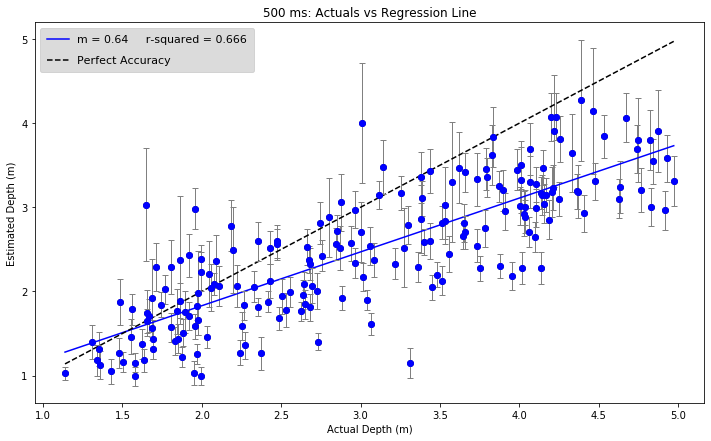

In [1498]:
from sklearn.linear_model import LinearRegression
#run regression
X_500 = np.array(stim_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black', alpha = 0.7);
plt.plot(X_500,y_predicted_500,color='blue', label = 'm = ' + str(round(reg_500.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_500.score(X_500, y_500)), 3)))
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_500, y_500, yerr=ste_500, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

slope: 0.031037    intercept: 0.149171
R-squared: 0.065724
Standard-error: 0.008489


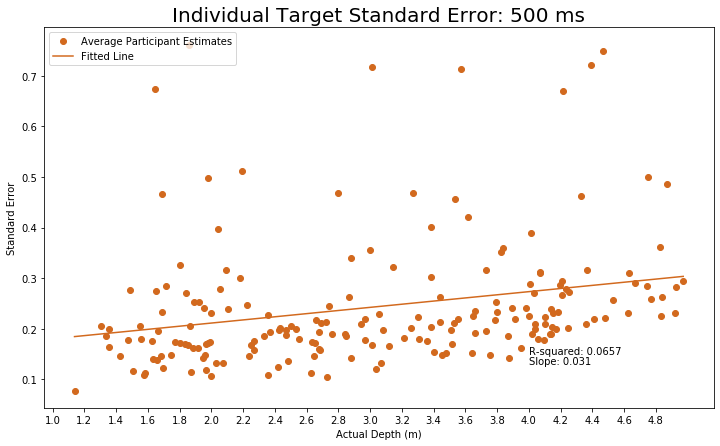

Average Standard Error 500 ms


0.24293976186239682

In [1499]:
plot_img_ste(stim_500, final_y_500, ste_500, 500)

avg_500 =np.mean(ste_500)
print("Average Standard Error 500 ms")
avg_500

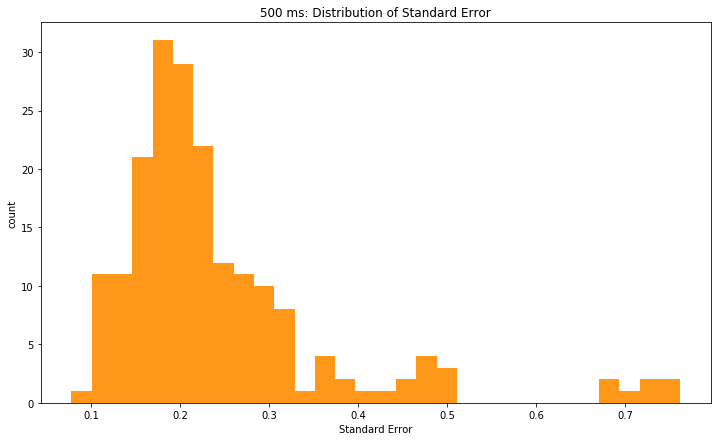

In [1500]:
plt.hist(ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.208813    intercept: 1.035189
R-squared: 0.063947
Standard-error: 0.057959


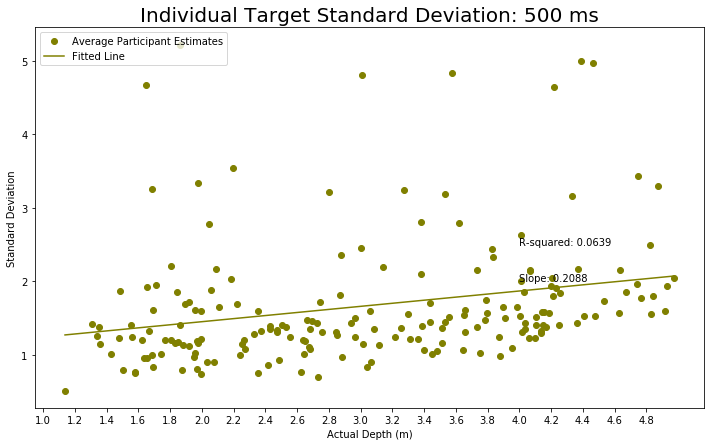

(0.20881319526838144,
 1.0351885670715228,
 0.2528773120023961,
 0.0004019783240334323,
 0.057959083169901934)

In [1501]:
plot_img_std(stim_500, final_y_500, std_500, 500)

m: [0.6763857]
b: 0.45372574081540185
R-squared:  0.6824502274466864


Text(0, 0.5, 'Residual')

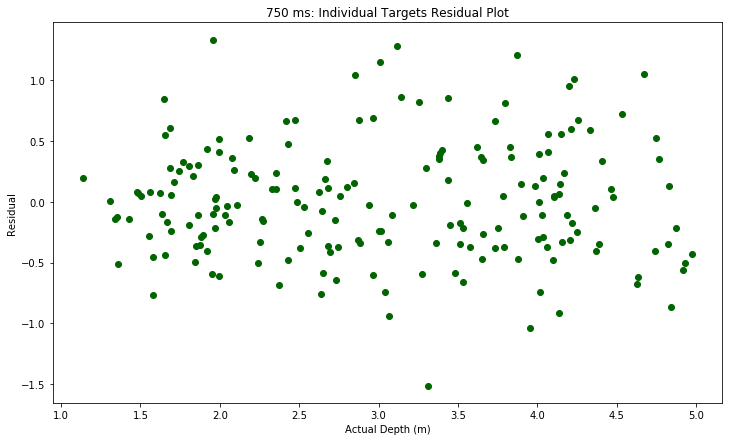

In [1502]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_750).reshape(-1,1)
y = final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_750 = y-y_predicted
plt.plot(X,residuals_750, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

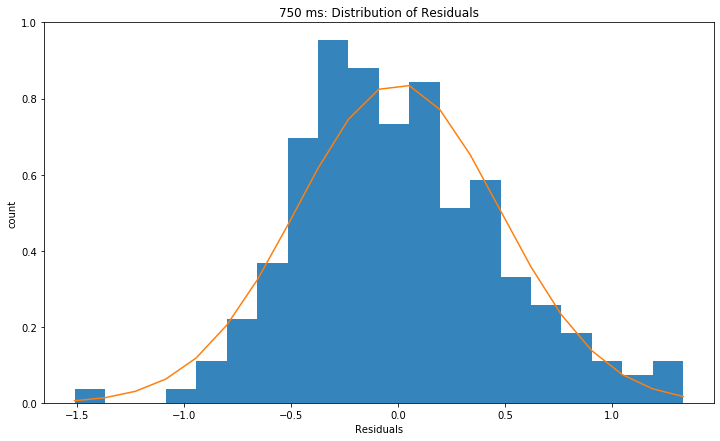

In [1503]:
plt.title('750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals_750, 20, density=1, alpha=0.9)
mu_750, sigma = scipy.stats.norm.fit(residuals_750)
best_fit_line_750 = scipy.stats.norm.pdf(bins, mu_750, sigma)
plt.plot(bins, best_fit_line_750)

plt.show()

m: [0.6763857]
b: 0.45372574081540185
R-squared:  0.6824502274466864


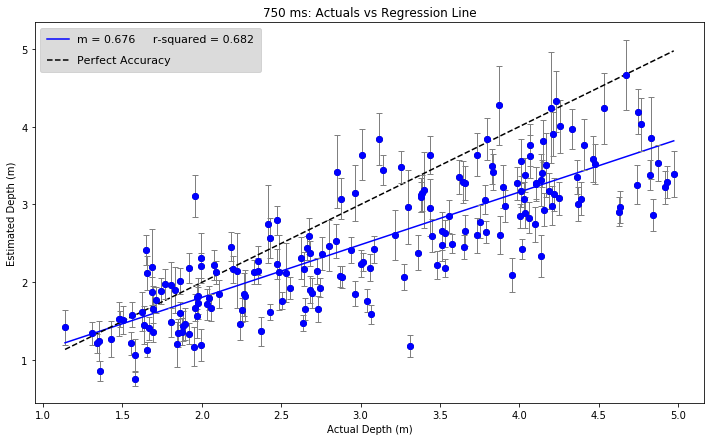

In [1504]:
from sklearn.linear_model import LinearRegression
#run regression
X_750 = np.array(stim_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black', alpha = 0.7);
plt.plot(X_750,y_predicted_750,color='blue', label = 'm = ' + str(round(reg_750.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_750.score(X_750, y_750)), 3)))
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_750, y_750, yerr=ste_750, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

In [1505]:
# X_750[-22], y_750[-22], final_x_750[-22]
# X_750[108], y_750[108], final_x_750[108]
X_750[39], y_750[39], final_x_750[39]

(array([1.956]),
 3.108736363636365,
 'depth_duration_stimuli/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1-target.png')

slope: 0.024649    intercept: 0.155007
R-squared: 0.072537
Standard-error: 0.006394


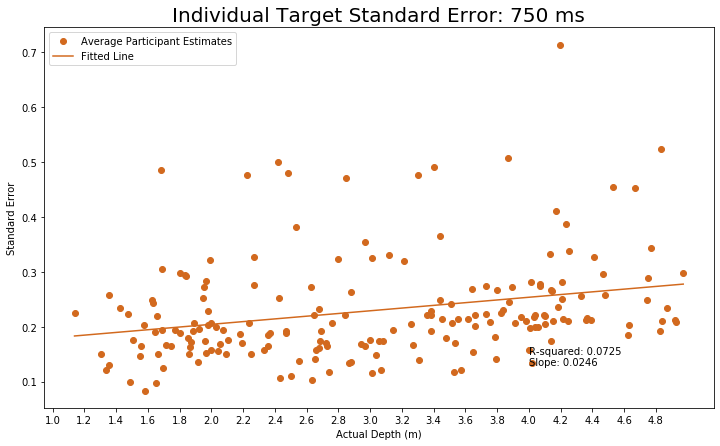

Average Standard Error 750 ms


0.22947539604331982

In [1506]:
plot_img_ste(stim_750, final_y_750, ste_750, 750)

avg_750 =np.mean(ste_750)
print("Average Standard Error 750 ms")
avg_750

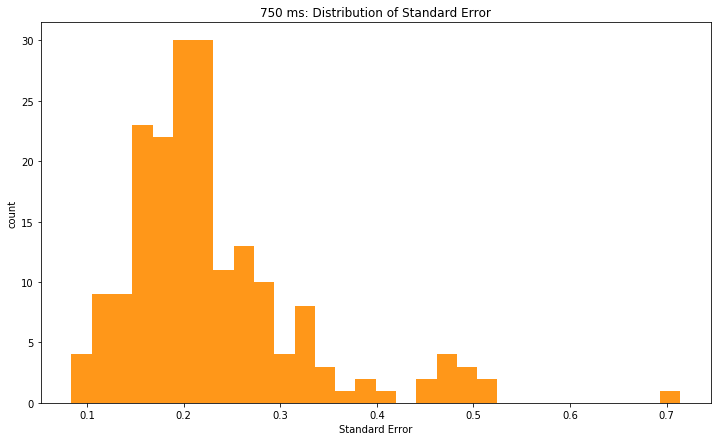

In [1507]:
plt.hist(ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

slope: 0.164224    intercept: 1.078034
R-squared: 0.069363
Standard-error: 0.043640


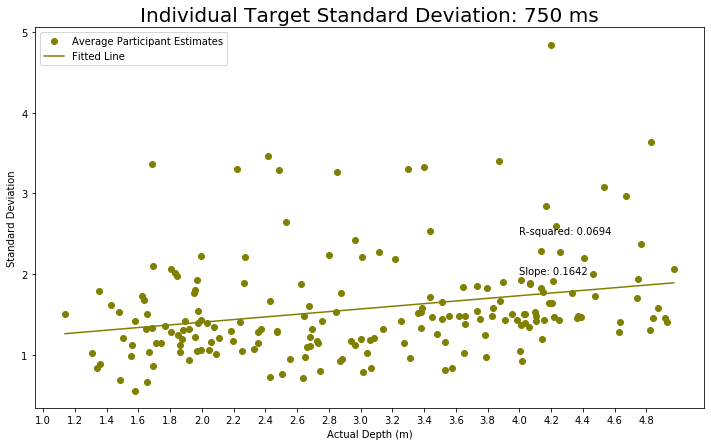

(0.16422415450630592,
 1.0780343608357927,
 0.2633682798202865,
 0.00022347591632480547,
 0.04364022281629959)

In [1508]:
plot_img_std(stim_750, final_y_750, std_750, 750)

m: [0.67314572]
b: 0.45754409118404027
R-squared:  0.6821961948910589


Text(0, 0.5, 'Residual')

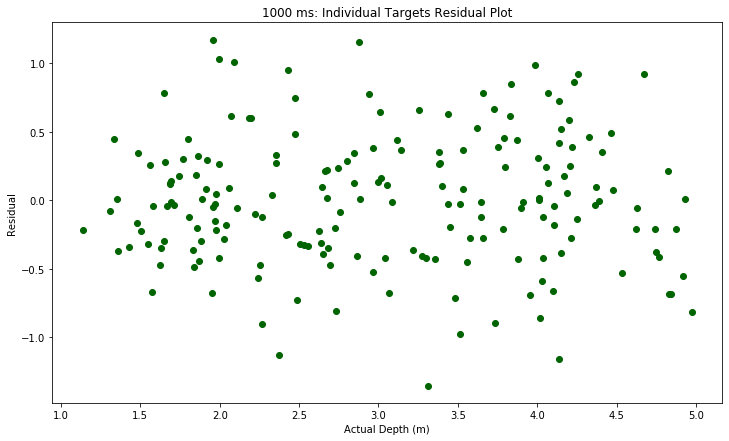

In [1509]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals_1000 = y-y_predicted
plt.plot(X,residuals_1000, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

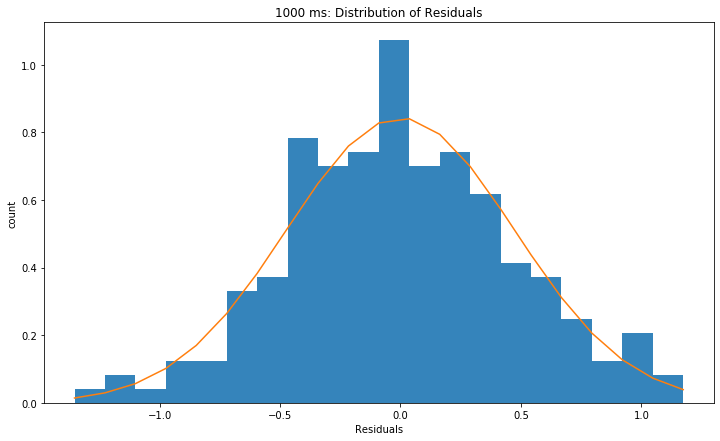

In [1510]:
plt.title('1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals_1000, 20, density=1, alpha=0.9)
mu_1000, sigma = scipy.stats.norm.fit(residuals_1000)
best_fit_line_1000 = scipy.stats.norm.pdf(bins, mu_1000, sigma)
plt.plot(bins, best_fit_line_1000)

plt.show()

m: [0.67314572]
b: 0.45754409118404027
R-squared:  0.6821961948910589


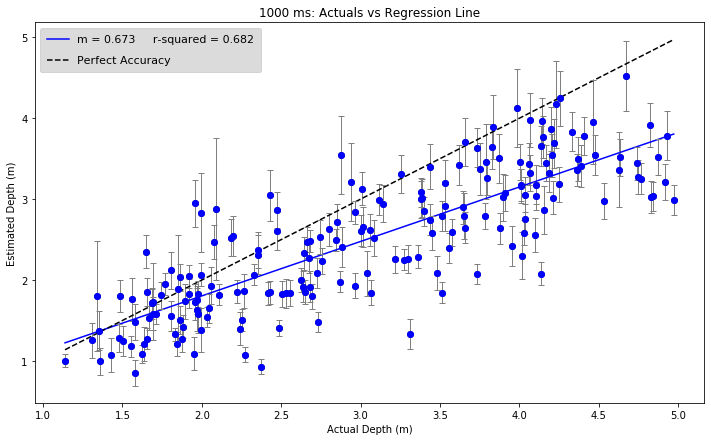

In [1511]:
from sklearn.linear_model import LinearRegression
#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black', alpha = 0.7);
plt.plot(X_1000,y_predicted_1000,color='blue', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))

plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
plt.errorbar(X_1000, y_1000, yerr=ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "blue", mec = "blue", capsize = 3)


legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')



#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

slope: 0.017794    intercept: 0.172366
R-squared: 0.030699
Standard-error: 0.007254


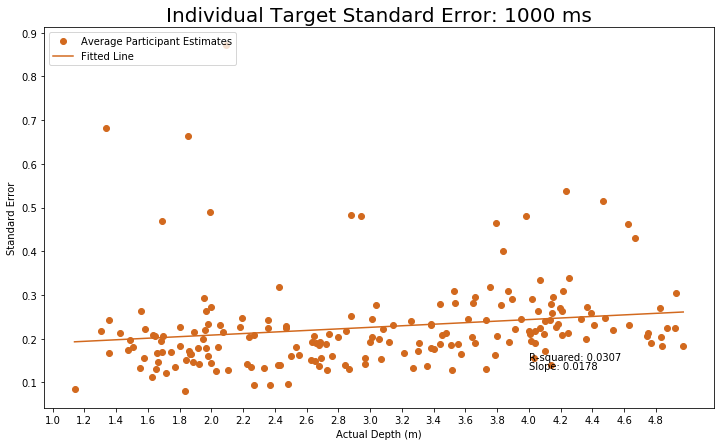

Average Standard Error 1000 ms


0.2261243823972355

In [1512]:
plot_img_ste(stim_1000, final_y_1000, ste_1000, 1000)

avg_1000 =np.mean(ste_1000)
print("Average Standard Error 1000 ms")
avg_1000

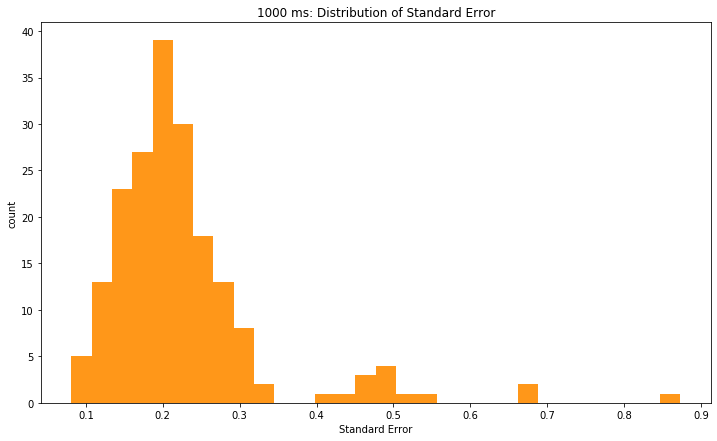

In [1513]:
plt.hist(ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

In [1514]:
ste_1000[52]
final_x_1000[52]

'depth_duration_stimuli/000878_2014-06-08_22-52-45_260595134347_rgbf000045-resize_2/000878_2014-06-08_22-52-45_260595134347_rgbf000045-resize_2-target.png'

slope: 0.118685    intercept: 1.197089
R-squared: 0.028764
Standard-error: 0.050033


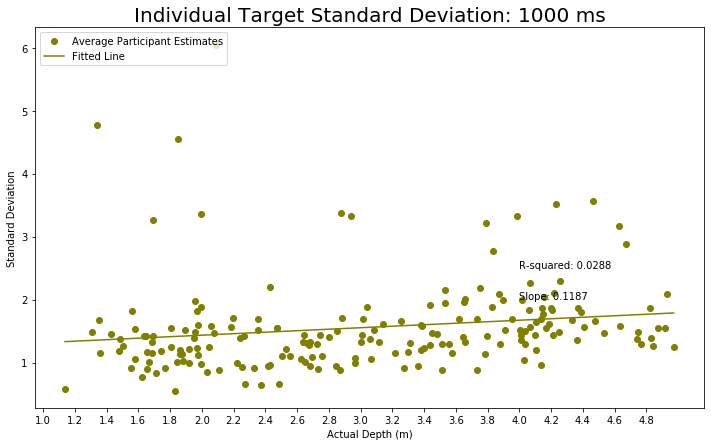

(0.11868455194814112,
 1.1970885552198471,
 0.16960037638808892,
 0.018684363659485413,
 0.0500325806271393)

In [1515]:
plot_img_std(stim_1000, final_y_1000, std_1000, 1000)

#### Summary Plots

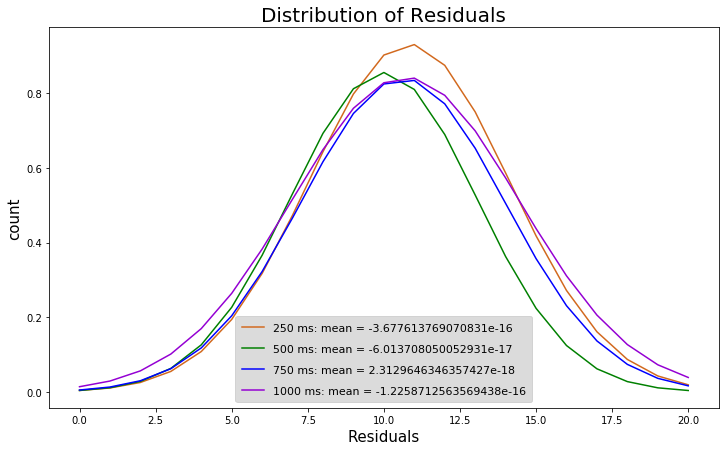

In [1516]:
plt.figure(figsize = [12, 7])
plt.title('Distribution of Residuals', fontsize = 20)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('count', fontsize = 15)

plt.plot(best_fit_line_250, color = 'chocolate', label = '250 ms: '
        + 'mean = ' + str(mu_250))
plt.plot(best_fit_line_500, color = 'green', label = '500 ms: '
        + 'mean = ' + str(mu_500))
plt.plot(best_fit_line_750, color = 'blue', label = '750 ms: '
        + 'mean = ' + str(mu_750))
plt.plot(best_fit_line_1000, color = 'darkviolet', label = '1000 ms: '
        + 'mean = ' + str(mu_1000))

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


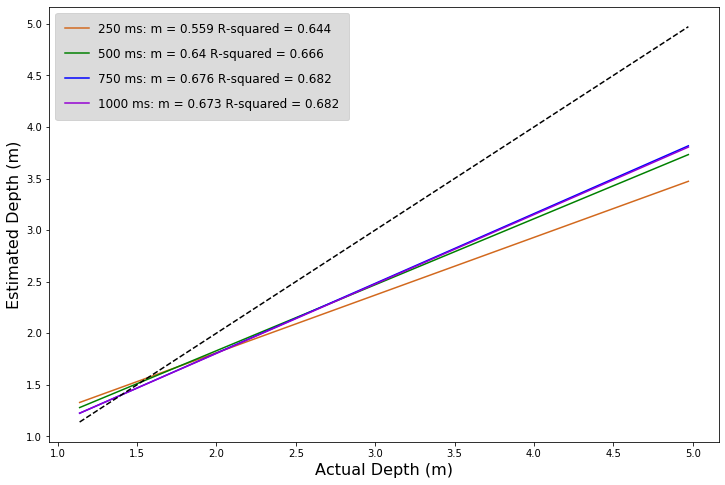

In [1517]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [12, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

# plt.title("Actual Depth vs Depth Estimate (N=192)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

(4.0, 0.0)

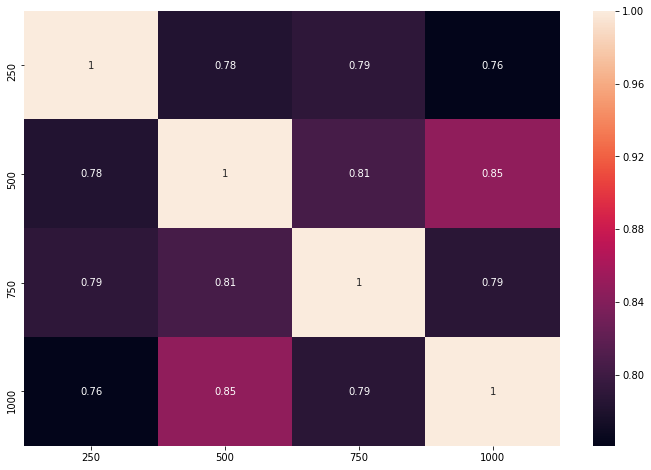

In [1518]:


from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'250': error_250,
        '500': error_500,
        '750': error_750,
        '1000': error_1000
        }


df = pd.DataFrame(data,columns=['250','500','750', '1000'])

plt.figure(figsize = [12, 8])
df_corr = df.corr()
ax = sns.heatmap(df_corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(4.0, 0.0)

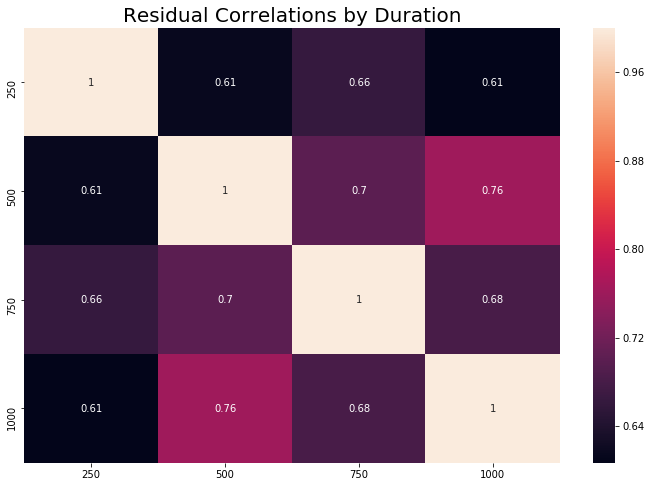

In [1519]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'250': residuals_250,
        '500': residuals_500,
        '750': residuals_750,
        '1000': residuals_1000
        }


df = pd.DataFrame(data,columns=['250','500','750', '1000'])

plt.figure(figsize = [12, 8])
plt.title("Residual Correlations by Duration", fontsize = 20)
df_corr = df.corr()
ax = sns.heatmap(df_corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)



#### Average change in target over time

In [1547]:
error_250 = np.array(stim_250) - np.array(y_250)
error_500 = np.array(stim_500) - np.array(y_500)
error_750 = np.array(stim_750) - np.array(y_750)
error_1000 = np.array(stim_1000) - np.array(y_1000)

avg_change_over_time = ((np.array(y_1000) - np.array(y_750)) + (np.array(y_750) - np.array(y_500)) + (np.array(y_500) - np.array(y_250)))/3

avg_change_in_accuracy = ((error_250 + error_500 + error_750 + error_1000)/4) 


change_in_accuracy_1000_250 =  error_1000 - error_250


avg_ste = (np.array(ste_250) + np.array(ste_500) + np.array(ste_750) + np.array(ste_1000))/4


m: [0.03791309]
b: -0.07789698666413986
R-squared:  0.07835026132863943


Text(0, 0.5, 'Average Change over Time')

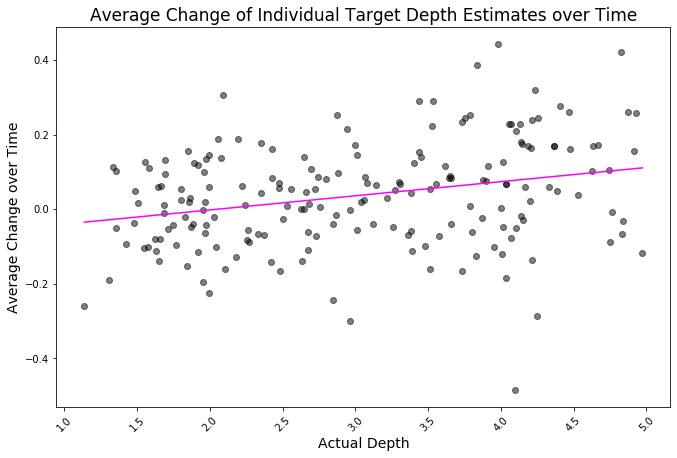

In [1269]:
from sklearn.linear_model import LinearRegression
#run regression

reg_time = LinearRegression().fit(X_250, avg_change_over_time)

#Generated Predictions
y_predicted_time = reg_time.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_time.coef_))
print("b: {0}".format(reg_time.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_time.score(X_250, avg_change_over_time))

plt.figure(figsize=[11, 7])
plt.title("Average Change of Individual Target Depth Estimates over Time", fontsize = 17)
plt.plot(X_250, avg_change_over_time, 'o', color='black', alpha = 0.5)
plt.plot(X_250,y_predicted_time,color='fuchsia')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Change over Time", fontsize = 14)


m: [0.36280021]
b: -0.5381727313665401
R-squared:  0.46550904172556296


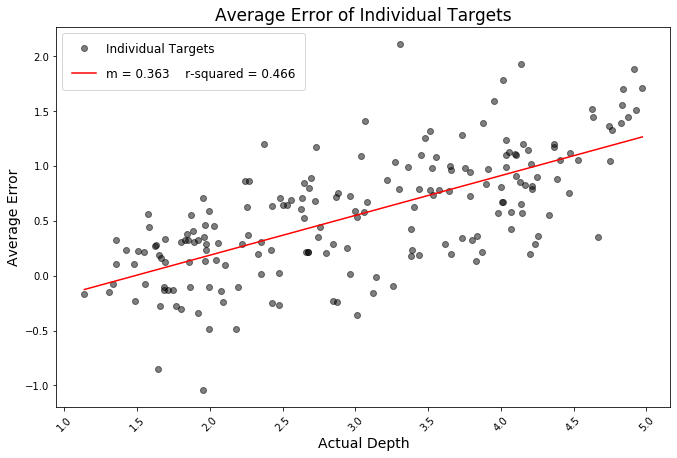

In [1550]:
from sklearn.linear_model import LinearRegression
#run regression

reg_acc = LinearRegression().fit(X_250, avg_change_in_accuracy)

#Generated Predictions
y_predicted_acc = reg_acc.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_acc.coef_))
print("b: {0}".format(reg_acc.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_acc.score(X_250, avg_change_in_accuracy))

plt.figure(figsize=[11, 7])
plt.title("Average Error of Individual Targets", fontsize = 17)
plt.plot(X_250, avg_change_in_accuracy, 'o', color='black', alpha = 0.5, label = "Individual Targets")
plt.plot(X_250,y_predicted_acc,color='red', label = "m = "+ str(round(float(reg_acc.coef_), 3)) + "    r-squared = "+ str(round(float(reg_acc.score(X_250, avg_change_in_accuracy)), 3)))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Error", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')

m: [0.02660805]
b: 0.15440427977603227
R-squared:  0.19344105710291568


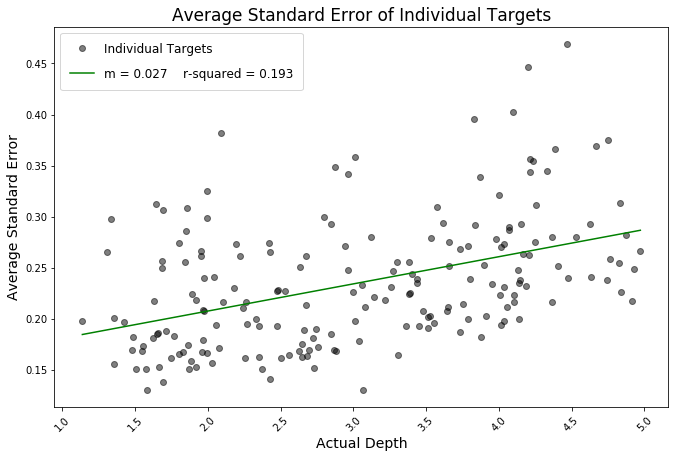

In [1549]:
from sklearn.linear_model import LinearRegression
#run regression

reg_ste = LinearRegression().fit(X_250, avg_ste)

#Generated Predictions
y_predicted_ste = reg_ste.predict(X_250)

#get coefficients and y intercept
print("m: {0}".format(reg_ste.coef_))
print("b: {0}".format(reg_ste.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_ste.score(X_250, avg_ste))

plt.figure(figsize=[11, 7])
plt.title("Average Standard Error of Individual Targets", fontsize = 17)
plt.plot(X_250, avg_ste, 'o', color='black', alpha = 0.5, label = "Individual Targets")
plt.plot(X_250,y_predicted_ste,color='green', label = "m = "+ str(round(float(reg_ste.coef_), 3)) + "    r-squared = "+ str(round(float(reg_ste.score(X_250, avg_ste)), 3)))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Actual Depth", fontsize = 14)
plt.ylabel("Average Standard Error", fontsize = 14)

legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('white')

In [ ]:
change_in_accuracy_1000_250

In [411]:
high_change_in_accuracy = [final_x_250[idx] for idx in range(len(avg_change_in_accuracy)) if avg_change_in_accuracy[idx] <= -1]
low_change_in_accuracy = [final_x_250[idx] for idx in range(len(avg_change_in_accuracy)) if -0.1 <= avg_change_in_accuracy[idx] <= 0.1]


high_change_in_accuracy

['depth_duration_stimuli/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1/002468_2014-06-28_20-38-39_260595134347_rgbf000045-resize_1-target.png']

#### Standard Deviation 

In [143]:
_250 = np.array(stim_250).reshape(1,-1)
avg_std_250 = np.std(_250[0])

_500 = np.array(stim_500).reshape(1,-1)
avg_std_500 = np.std(_500[0])

_750 = np.array(stim_750).reshape(1,-1)
avg_std_750 = np.std(_750[0])

_1000 = np.array(stim_1000).reshape(1,-1)
avg_std_1000 = np.std(_1000[0])


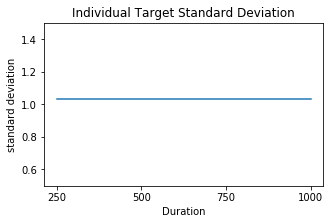

In [146]:
plt.figure(figsize = [5, 3])
plt.title('Individual Target Standard Deviation', fontsize = 12)
plt.xlabel('Duration', fontsize = 10)
plt.ylabel('standard deviation', fontsize = 10)
plt.ylim([0.5, 1.5])

durations = ['250', '500', '750', '1000']
stds = [avg_std_250, avg_std_500, avg_std_750, avg_std_1000]

plt.plot(durations, stds)

In [451]:
from scipy.spatial.transform import Rotation as R

#converts the rotation matrix in extrinsics.txt from string to a numpy array 
def rotationmatrix(matrix_path):
    matrixtext = open(matrix_path).read()
    
    x00 = float(matrixtext.split('\t')[0].split(' ')[0])
    x01 = float(matrixtext.split('\n')[0].split(' ')[1])
    x02 = float(matrixtext.split('\n')[0].split(' ')[2])
    
    x10 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[1].split(' ')[1])
    x12 = float(matrixtext.split('\n')[1].split(' ')[2])
    
    x20 = float(matrixtext.split('\n')[2].split(' ')[0])
    x21 = float(matrixtext.split('\n')[2].split(' ')[1])
    x22 = float(matrixtext.split('\n')[2].split(' ')[2])
    
    #list of the matrix values excluding the 3rd column of just zeroes 
    matrixlist = [[x00, x01, x02], [x10, x11, x12], [x20, x21, x22]]
    
    #creates 3x3 array of the rotation matrix
    matrixarray = np.full((3,3), matrixlist)
    
    return matrixarray

def rotationMatrixToEulerAngles(path):
    R = rotationmatrix(path)
    #assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

# Output - final roll, pitch, yaw values in radians and degrees 
def imageExtrinsics(path):
    in_array = rotationMatrixToEulerAngles(path)
    #print ("Radian values : \n", in_array) 

    degree_Values = np.degrees(in_array) 
    #print ("\nDegree values : \n", degree_Values) 
    
#     print ("\nRoll in Degrees : \n", degree_Values[0]) 
#     print ("\nPitch in Degrees : \n", degree_Values[1]) 
#     print ("\nYaw in Degrees : \n", degree_Values[2]) 
    
    return degree_Values[0], degree_Values[1], degree_Values[2]


def extrinsics_distribution(path, kinectv2):
    targetfolder = path.split('/')[1]
    if len(targetfolder) == 59:     
        imagefolder = path.split('/')[1][:-2]
    else:
        imagefolder = path.split('/')[1][:-3]

    extpath = kinectv2 + '/' + imagefolder + '/extrinsics' 
    fname = os.listdir(extpath)[0]
    if fname != '.ipynb_checkpoints':
        extrinsics = imageExtrinsics(extpath + '/' + fname)
    # roll, pitch, yaw
    return extrinsics[0], extrinsics[1], extrinsics[2]


In [1271]:
kinectv2_path = '/Users/prachimahableshwarkar/Documents/GW/2019-2020/code/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x 

rolls = [extrinsics_distribution(path, kinectv2_path)[0] for path in final_x_250]
pitches = [extrinsics_distribution(path, kinectv2_path)[1] for path in final_x_250]
yaws = [extrinsics_distribution(path, kinectv2_path)[2] for path in final_x_250]

residuals = [residuals_250, residuals_500, residuals_750, residuals_1000]

#### To get the p-value remove the [0] after the pearsonr function

In [1272]:
roll_corrs = [scipy.stats.pearsonr(rolls, resid_dur)[0] for resid_dur in residuals]

pitch_corrs = [scipy.stats.pearsonr(pitches, resid_dur)[0] for resid_dur in residuals]

yaw_corrs = [scipy.stats.pearsonr(yaws, resid_dur)[0] for resid_dur in residuals]


In [485]:
# plt.figure(figsize = [7, 5])
# _ = plt.hist(yaws, 100, density=1, alpha=0.9)


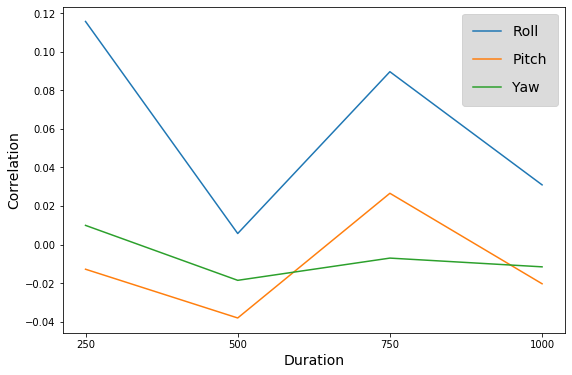

In [1525]:
plt.figure(figsize = [9, 6])
# plt.title('Camera Extrinsics: Correlation with Residuals', fontsize = 17)
plt.xlabel('Duration', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)

durations = ['250', '500', '750', '1000']

plt.plot(durations, roll_corrs, label = 'Roll')
plt.plot(durations, pitch_corrs, label = 'Pitch')
plt.plot(durations, yaw_corrs, label = 'Yaw')

legend = plt.legend(loc = 0, fontsize = 14, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#### Normalized data

In [1274]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
normalized_trial_plot_data = trial_normalized_final
##############################

n_final_x_250 = normalized_trial_plot_data[0][0]
n_final_y_250 = normalized_trial_plot_data[1][0]
n_ste_250 = normalized_trial_plot_data[2][0]
n_stim_250 = normalized_trial_plot_data[3][0]
n_std_250 = normalized_trial_plot_data[4][0]

n_final_x_500 = normalized_trial_plot_data[0][1]
n_final_y_500 = normalized_trial_plot_data[1][1]
n_ste_500 = normalized_trial_plot_data[2][1]
n_stim_500 = normalized_trial_plot_data[3][1]
n_std_500 = normalized_trial_plot_data[4][1]

n_final_x_750 = normalized_trial_plot_data[0][2]
n_final_y_750 = normalized_trial_plot_data[1][2]
n_ste_750 = normalized_trial_plot_data[2][2]
n_stim_750 = normalized_trial_plot_data[3][2]
n_std_750 = normalized_trial_plot_data[4][2]

n_final_x_1000 = normalized_trial_plot_data[0][3]
n_final_y_1000 = normalized_trial_plot_data[1][3]
n_ste_1000 = normalized_trial_plot_data[2][3]
n_stim_1000 = normalized_trial_plot_data[3][3]
n_std_1000 = normalized_trial_plot_data[4][3]

## Split data randomly into half: Correlate Residuals

In [195]:
import random
from sklearn.linear_model import LinearRegression
import scipy
from scipy import stats 

def get_stimuli(data):
    """
    Args:
        data = [df_250, df_500, df_750, df_1000]
    Returns:
        all_stimuli = [imgs_250, imgs_500, imgs_750, imgs_1000]
    """
    
    all_stimuli = []
    for df in data:
        stimuli = set()
        for idx, row in df.iterrows():
            stimulus = row["stimulus"]
            stimuli.add(stimulus)
        all_stimuli.append(list(stimuli))
        
    return all_stimuli

def split_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 

    """
    
    stimuli = get_stimuli(data)
    splits = [None, None, None, None]
    duration_split_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        splits[i] = [split1[0], split2[0]]
        
        duration_split_corrs[i] = scipy.stats.pearsonr(split1[0], split2[0])[0] 

    
    return duration_split_corrs # raw splits 

def split_std_error(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard errors for each duration 

    """
    
    stimuli = get_stimuli(data)
    stderrors = [None, None, None, None]
    duration_avg_stderr = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_stderr = stats.sem(split1[0])
        split2_stderr = stats.sem(split2[0])

        stderrors[i] = [split1_stderr, split2_stderr]
        
        duration_avg_stderr[i] = np.mean(stderrors[i])
        

    return duration_avg_stderr


def split_std(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        Avg of the split standard deviations for each duration 

    """
    
    stimuli = get_stimuli(data)
    stds = [None, None, None, None]
    duration_avg_std = [None, None, None, None ]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):
                                                               int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        split1_std = np.std(split1[0])
        split2_std = np.std(split2[0])

        stds[i] = [split1_std, split2_std]
        
        duration_avg_std[i] = np.mean(stds[i])
        

    return duration_avg_std

def split_residuals(data, proportion, duration, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
        proportion - amount of data in each split (0.5 for 50/50 split)
        duration = index for the duration condition i.e. 0 for 250, etc. 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list   
        
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        
        if i == duration: 
            return stim_actual, split1_residuals, split2_residuals
        


def split_residual_correlations(data, proportion, normalize = False, avg_participant_estimate = None):
    """
    Args:
        Data post outlier removal: i.e. cleaned_data --> list of duration dfs 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
        
    Dataframs is computationally expensive --> extract raw data and compute operations within functions using np.array
    declare numpy array --> add to that 
    --> once next sequence is set you can declare a numpy array of the size 256 (number of images)
    """
    
    stimuli = get_stimuli(data)
    
    duration_residual_corrs = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_corrs[i] = scipy.stats.pearsonr(split1_residuals[0], split2_residuals[0])[0] 
        

    return duration_residual_corrs

def generate_n_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON REGRESSION CORRELATIONS
    """

    corrs = np.array([split_residual_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_raw_split_correlations(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON RAW SPLITS 
    """

    corrs = np.array([split_correlations(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(corrs, axis = 0) 
    return corrs, mean

def generate_n_split_std_error(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD ERROR AVGS
    """

    avgs = np.array([split_std_error(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean


def generate_n_split_std(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON STD AVGS
    """

    avgs = np.array([split_std(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(avgs, axis = 0) 
    return avgs, mean
              

In [147]:
from sklearn.metrics import r2_score

def split_residual_rsquare(data, proportion, normalize = False, avg_participant_estimate = None):
    
    stimuli = get_stimuli(data)
    
    duration_residual_r2 = [None, None, None, None]
    for i in range(4):
        split1 = [] 
        split2 = []
        stim_actual = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            stim_df_estimates = stim_df['depth_estimate'].tolist()
            stim_df_actual = stim_df['actual_depth'].tolist()[0]
            random.shuffle(stim_df_estimates)
            
            estim_avg_df0 = np.mean(np.array(stim_df_estimates[0:int(len(stim_df_estimates)*proportion)]))
            estim_avg_df1 = np.mean(np.array(stim_df_estimates[int(len(stim_df_estimates)*proportion):int(len(stim_df_estimates)*proportion) * 2]))
   
            split1.append(estim_avg_df0) 
            split2.append(estim_avg_df1)
            stim_actual.append(stim_df_actual)
        
        split1 = np.array(split1).reshape(1,-1)
        split2 = np.array(split2).reshape(1,-1)
        if normalize == True:
            stim_actual = np.array(stim_actual).reshape(1,-1)/avg_participant_estimate
        else:
            stim_actual = np.array(stim_actual).reshape(1,-1)

        reg_split1 = LinearRegression().fit(split1, stim_actual)
        reg_split2 = LinearRegression().fit(split2, stim_actual)

        #Generated Predictions
        y_predicted_s1 = reg_split1.predict(stim_actual)
        split1_residuals = split1-y_predicted_s1
        
        y_predicted_s2 = reg_split2.predict(stim_actual)
        split2_residuals = split2-y_predicted_s2
        # add duration corr to list                                
        duration_residual_r2[i] = r2_score(split1_residuals[0], split2_residuals[0])
        

    return duration_residual_r2

def generate_n_split_r2(n, data, proportion, normalize = False, avg_participant_estimate = None):
    """
    RUN ON SPLIT RESIDUAL R^2
    """

    residual_r2s = np.array([split_residual_rsquare(data, proportion, normalize, avg_participant_estimate) for i in range(n)])
    mean = np.mean(residual_r2s, axis = 0) 
    return residual_r2s, mean

#### Split Residual R-Squared 

In [1275]:
r2_100_05 = generate_n_split_r2(10, duration_data, 0.5)
r2_100_04 = generate_n_split_r2(10, duration_data, 0.4)
r2_100_03 = generate_n_split_r2(10, duration_data, 0.3)
r2_100_02 = generate_n_split_r2(10, duration_data, 0.2)

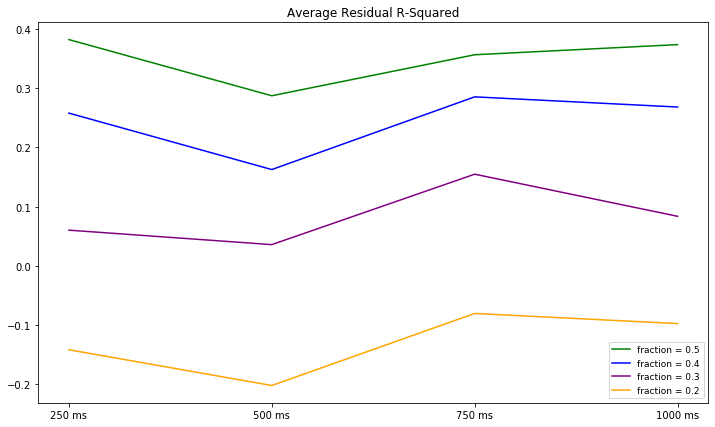

In [1276]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

Text(0.5, 1, 'Raw Split Residual R-Squared')

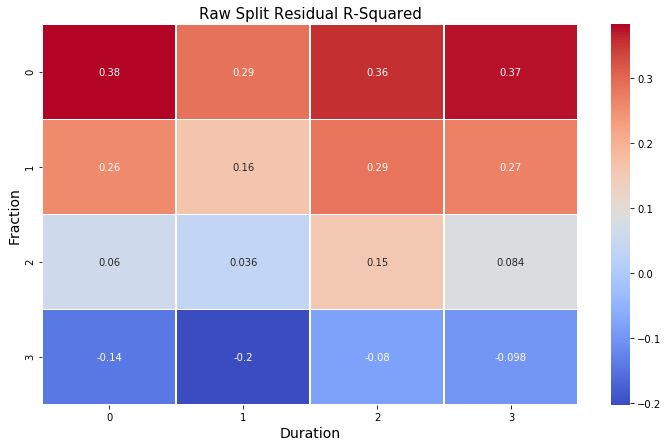

In [1378]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize = [12, 7])
a = [r2_100_05[1], r2_100_04[1], r2_100_03[1], r2_100_02[1]]
ax = sns.heatmap(a, linewidth=0.5, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Duration', fontsize = 14)

plt.ylabel('Fraction', fontsize = 14)



plt.title('Raw Split Residual R-Squared', fontsize = 15)

In [1361]:
len(r2_100_05[0])

10

In [1277]:
norm_r2_100_05 = generate_n_split_std_error(10, normalized_duration_data, 0.5, True, average_depth_estimate)
norm_r2_100_04 = generate_n_split_std_error(10, normalized_duration_data, 0.4, True, average_depth_estimate)
norm_r2_100_03 = generate_n_split_std_error(10, normalized_duration_data, 0.3, True, average_depth_estimate)
norm_r2_100_02 = generate_n_split_std_error(10, normalized_duration_data, 0.2, True, average_depth_estimate)

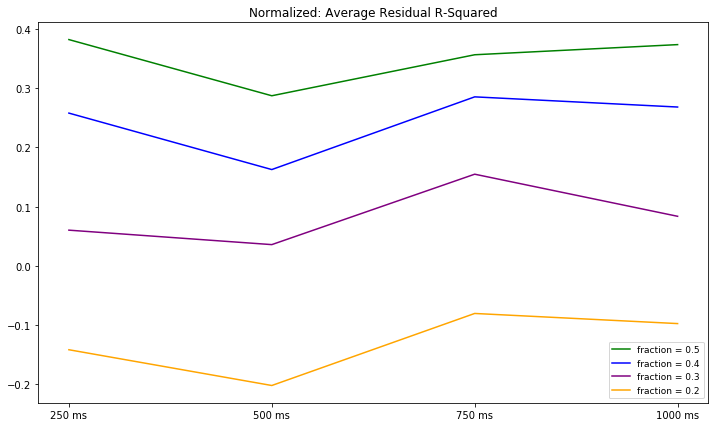

In [1372]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

Text(0.5, 1, 'Normalized Split Residual R-Squared')

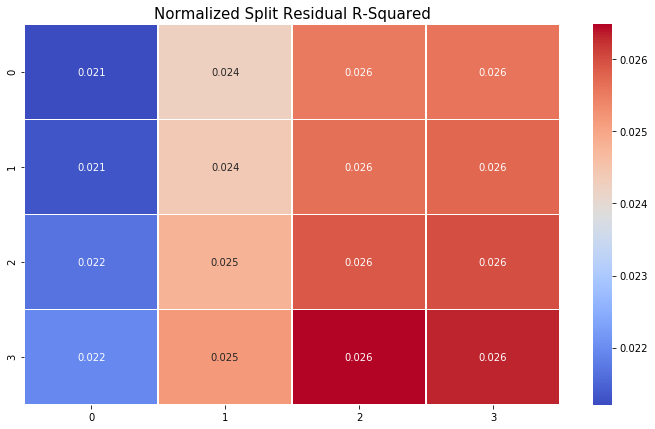

In [1373]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = [12, 7])
b = [norm_r2_100_05[1], norm_r2_100_04[1], norm_r2_100_03[1], norm_r2_100_02[1]]
ax = sns.heatmap(b, linewidth=0.5, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)



plt.title('Normalized Split Residual R-Squared', fontsize = 15)

#### Correlation between the splits: non-normalized data 

In [145]:
splits_05 = generate_n_raw_split_correlations(100, duration_data, 0.5)
splits_04 = generate_n_raw_split_correlations(100, duration_data, 0.4)
splits_03 = generate_n_raw_split_correlations(100, duration_data, 0.3)
splits_02 = generate_n_raw_split_correlations(100, duration_data, 0.2)


In [149]:
norm_splits_05 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.5)
norm_splits_04 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.4)
norm_splits_03 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.3)
norm_splits_02 = generate_n_raw_split_correlations(100, normalized_duration_data, 0.2)


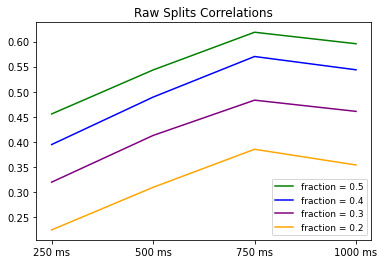

In [147]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Raw Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

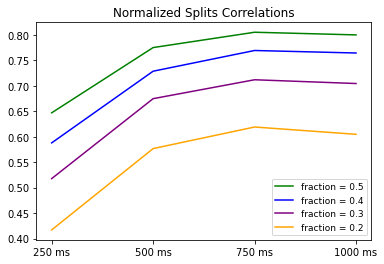

In [150]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_splits_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_splits_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_splits_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_splits_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized Splits Correlations')
plt.legend(fontsize = 9)
plt.show()

### Avg standard error of splits 

In [986]:
ste_100_05 = generate_n_split_std_error(10, duration_data, 0.5)
ste_100_04 = generate_n_split_std_error(10, duration_data, 0.4)
ste_100_03 = generate_n_split_std_error(10, duration_data, 0.3)
ste_100_02 = generate_n_split_std_error(10, duration_data, 0.2)

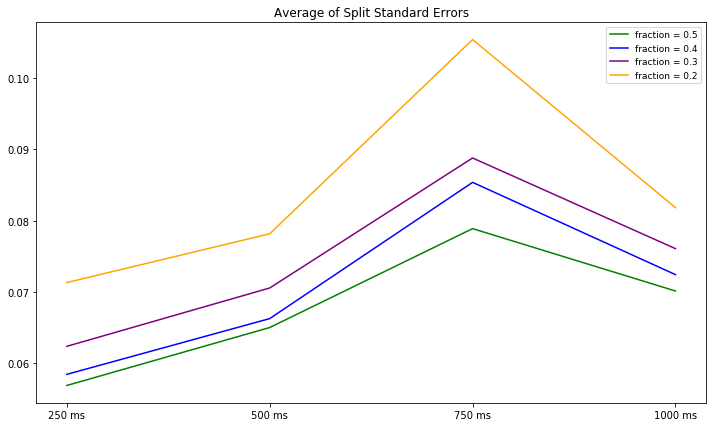

In [987]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

In [156]:
norm_ste_100_05 = generate_n_split_std_error(10, normalized_duration_data, 0.5)
norm_ste_100_04 = generate_n_split_std_error(10, normalized_duration_data, 0.4)
norm_ste_100_03 = generate_n_split_std_error(10, normalized_duration_data, 0.3)
norm_ste_100_02 = generate_n_split_std_error(10, normalized_duration_data, 0.2)

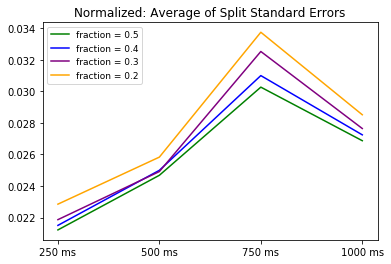

In [158]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_ste_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_ste_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_ste_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_ste_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Errors')
plt.legend(fontsize = 9)
plt.show()

### Avg standard deviation of splits 

In [307]:
std_100_05 = generate_n_split_std(10, duration_data, 0.5)
std_100_04 = generate_n_split_std(10, duration_data, 0.4)
std_100_03 = generate_n_split_std(10, duration_data, 0.3)
std_100_02 = generate_n_split_std(10, duration_data, 0.2)

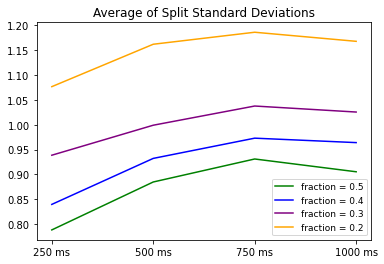

In [308]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

In [ ]:
norm_std_100_05 = generate_n_split_std(100, normalized_duration_data, 0.5)
norm_std_100_04 = generate_n_split_std(100, normalized_duration_data, 0.4)
norm_std_100_03 = generate_n_split_std(100, normalized_duration_data, 0.3)
norm_std_100_02 = generate_n_split_std(100, normalized_duration_data, 0.2)

In [ ]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, norm_std_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, norm_std_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, norm_std_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, norm_std_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average of Split Standard Deviations')
plt.legend(fontsize = 9)
plt.show()

### Correlation between the residuals of splits

In [ ]:
raw_100_05 = generate_n_split_correlations(100, cleaned_data, 0.5)
raw_100_04 = generate_n_split_correlations(100, cleaned_data, 0.4)
raw_100_03 = generate_n_split_correlations(100, cleaned_data, 0.3)
raw_100_02 = generate_n_split_correlations(100, cleaned_data, 0.2)

In [ ]:
# raw_10000_05 = generate_n_split_correlations(10000, cleaned_data, 0.5)
# raw_10000_04 = generate_n_split_correlations(10000, cleaned_data, 0.4)
# raw_10000_03 = generate_n_split_correlations(10000, cleaned_data, 0.3)
# raw_10000_02 = generate_n_split_correlations(10000, cleaned_data, 0.2)

In [107]:
avg_average_particip_estim = 2.4779054712373956

In [113]:
normalized_100_05 = generate_n_split_correlations(100, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
normalized_100_04 = generate_n_split_correlations(100, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
normalized_100_03 = generate_n_split_correlations(100, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
normalized_100_02 = generate_n_split_correlations(100, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

In [ ]:
# normalized_10000_05 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.5, True, avg_average_particip_estim)
# normalized_10000_04 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.4, True, avg_average_particip_estim)
# normalized_10000_03 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.3, True, avg_average_particip_estim)
# normalized_10000_02 = generate_n_split_correlations(10000, normalized_cleaned_data, 0.2, True, avg_average_particip_estim)

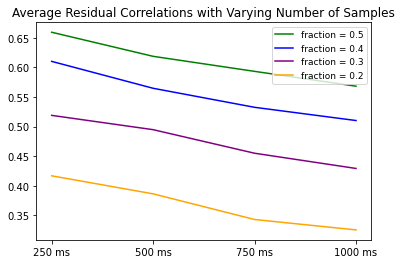

In [122]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, raw_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, raw_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, raw_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, raw_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

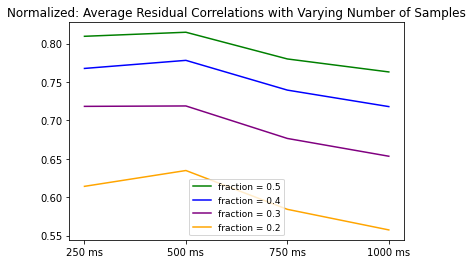

In [114]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, normalized_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, normalized_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, normalized_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, normalized_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual Correlations with Varying Number of Samples')
plt.legend(fontsize = 9)
plt.show()

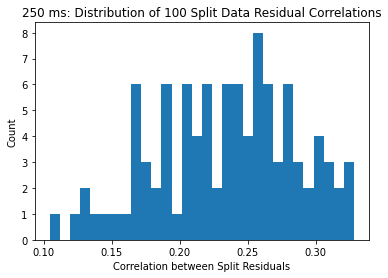

0.23373248798972746


In [286]:
lst_100_split_250_corrs = [elem[0] for elem in raw_100_05[0]]

plt.hist(lst_100_split_250_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'250 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_250_corrs)))

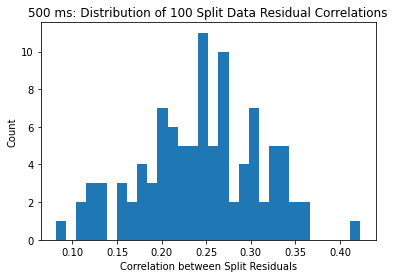

0.24456522832811065


In [285]:
lst_100_split_500_corrs = [elem[1] for elem in raw_100_05[0]]

plt.hist(lst_100_split_500_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'500 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_500_corrs)))

In [92]:
# lst_100_split_750_corrs = [elem[2] for elem in raw_100_05[0]]

# plt.hist(split1_750ms_05_n1, density = False, bins=30)
# plt.xlabel('Correlation between Split Residuals')
# plt.ylabel('Count')
# plt.title(r'750 ms: Distribution of 100 Split Data Residual Correlations')
# plt.show()

# print(np.mean(np.array(lst_100_split_750_corrs)))

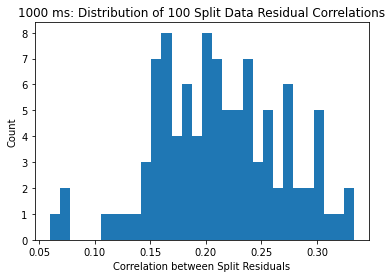

0.21255502738709686


In [283]:
lst_100_split_1000_corrs = [elem[3] for elem in raw_100_05[0]]

plt.hist(lst_100_split_1000_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'1000 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_1000_corrs)))

#### Plot Split Residuals 

In [1379]:
# split residuals for 750ms with fraction = 0.5, for n=1 where n is the number of iterations
#data, proportion, duration, normalize = False, avg_participant_estimate = None

actual_750ms_05_n1, split1_750ms_05_n1, split2_750ms_05_n1 = split_residuals(duration_data, 0.5, 2)

In [1380]:
actual_250ms_05_n1, split1_250ms_05_n1, split2_250ms_05_n1 = split_residuals(duration_data, 0.5, 0)

Text(0, 0.5, 'Split 2 Residuals')

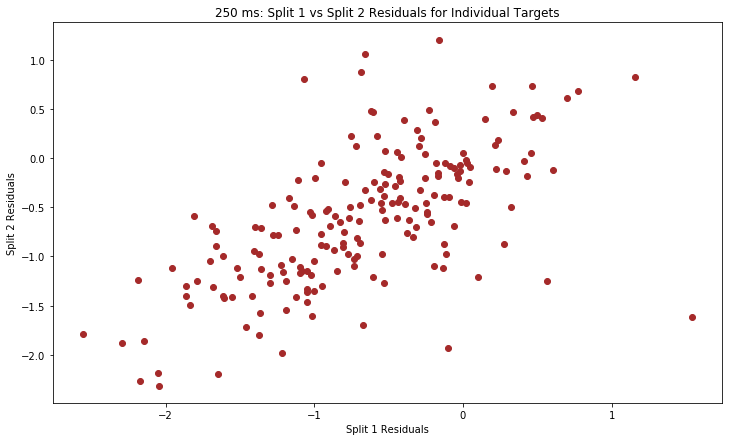

In [1381]:
plt.plot(split1_250ms_05_n1,split2_250ms_05_n1, 'o', color='brown')
plt.title("250 ms: Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

In [1383]:
norm_actual_250ms_05_n1, norm_split1_250ms_05_n1, norm_split2_250ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 0, True, average_depth_estimate)

norm_actual_500ms_05_n1, norm_split1_500ms_05_n1, norm_split2_500ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 1, True, average_depth_estimate)

norm_actual_750ms_05_n1, norm_split1_750ms_05_n1, norm_split2_750ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 2, True, average_depth_estimate)

norm_actual_1000ms_05_n1, norm_split1_1000ms_05_n1, norm_split2_1000ms_05_n1 = split_residuals(normalized_duration_data, 0.5, 3, True, average_depth_estimate)


Text(0, 0.5, 'Split 2 Residuals')

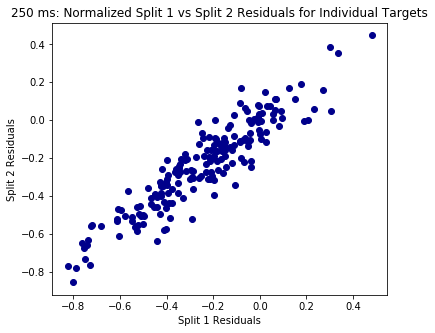

In [1390]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_250ms_05_n1,norm_split2_250ms_05_n1, 'o', color='darkblue')
plt.title("250 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

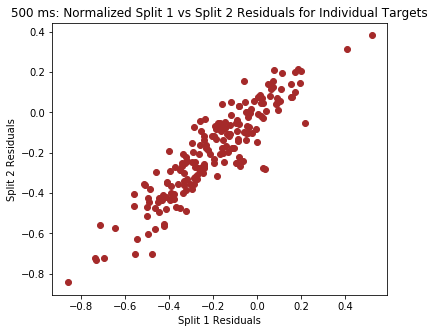

In [1391]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_500ms_05_n1,norm_split2_500ms_05_n1, 'o', color='brown')
plt.title("500 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

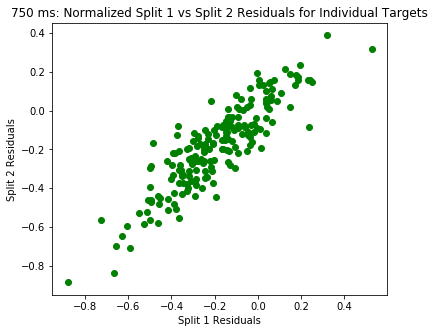

In [1389]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_750ms_05_n1,norm_split2_750ms_05_n1, 'o', color='green')
plt.title("750 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0, 0.5, 'Split 2 Residuals')

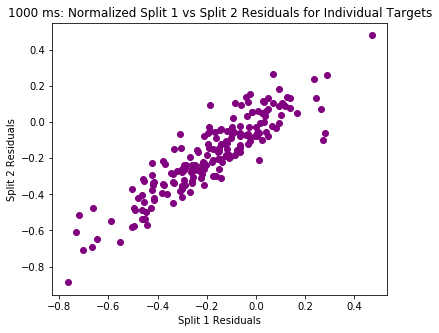

In [1388]:
plt.figure(figsize = [6, 5])
plt.plot(norm_split1_1000ms_05_n1,norm_split2_1000ms_05_n1, 'o', color='purple')
plt.title("1000 ms: Normalized Split 1 vs Split 2 Residuals for Individual Targets")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

Text(0.5, 1.0, 'SUN-RGBD Scene Category Distribution')

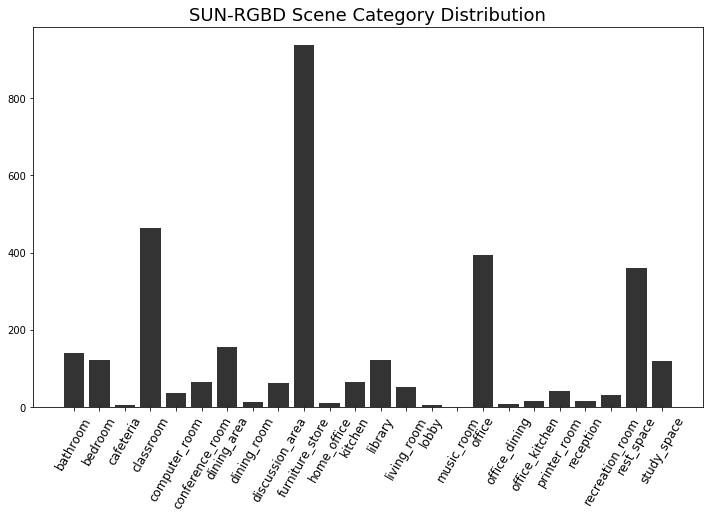

In [1446]:
scene_categories = {'bathroom': 139,
 'bedroom': 121,
 'cafeteria': 5,
 'classroom': 463,
 'computer_room': 37,
 'conference_room': 64,
 'dining_area': 156,
 'dining_room': 12,
 'discussion_area': 62,
 'furniture_store': 938,
 'home_office': 10,
 'kitchen': 66,
 'library': 123,
 'living_room': 51,
 'lobby': 5,
 'music_room': 1,
 'office': 394,
 'office_dining': 9,
 'office_kitchen': 16,
 'printer_room': 43,
 'reception': 16,
 'recreation_room': 31,
 'rest_space': 361,
 'study_space': 119}


fig = plt.figure()
keys = scene_categories.keys()
values = scene_categories.values()
plt.xticks(rotation = 60, fontsize = 12)
plt.bar(keys, values, color = 'black', alpha = 0.8)
plt.title("SUN-RGBD Scene Category Distribution", fontsize = 18)